# Compas Dataset: Calibration ver

In this notebook the optimal Deferral Net configuration is chosen, and the deferral tau threshold is calibrated.

Following the BRIDGET experimental pipeline, the Deferral Net is trained on the data predicted by the Human-in-Command process, then subsequently tested on the validation data to produce the optimal Tau deferral coefficient.

The architecture for the Nets to be tested are [(16, 8), (32, 16), (64, 32)].

The optimizer used is ADAM

The dropout rate was set to 0.2 to ensure the nets dont overfit initially, then tested up to 0.5



### Libraries and functions

In [1]:
# retrieving all libraries
%load_ext autoreload
%autoreload 2




import os
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import matplotlib.pyplot as plt
import random



from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from river import rules, tree, datasets, drift, metrics, evaluate
from river import imblearn
from river import preprocessing
from river import metrics
from river import ensemble, linear_model, forest

from torchsummary import summary
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR

from ignite.metrics import Accuracy, Loss
from ignite.engine import Engine, Events, create_supervised_trainer, create_supervised_evaluator
from ignite.handlers import EarlyStopping, ModelCheckpoint
from ignite.contrib.handlers import global_step_from_engine


from xailib.models.sklearn_classifier_wrapper import sklearn_classifier_wrapper


from bridget_utils import *
from classes import BetaUser, DeferralNet, PyTorchWrapper, RiverModelWrapper
from b_xai_test import BRIDGET, HiC, MiC


26-Feb-17 15:38:07 fatf.utils.array.tools INFO     Using numpy's numpy.lib.recfunctions.structured_to_unstructured as fatf.utils.array.tools.structured_to_unstructured and fatf.utils.array.tools.structured_to_unstructured_row.


In [2]:
def set_all_seeds(seed=42):
    
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
   
    try:
        import torch
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    except ImportError:
        pass

set_all_seeds(42)

In [3]:
def plot_confusion_matrix(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predictions')
    plt.ylabel('Ground Truths')
    plt.title('Confusion Matrix, DefNet')
    plt.show()
    
    print(classification_report(all_labels, all_preds))

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Expert: Accurate, Trusting

### Iter 1

In [5]:
# retrieving the calibration split 

iter=1
df_val= pd.read_csv(r"processed_data\compas\calibration_datasets\iter_1\acc_t_calibration.csv")
df_val= df_val.rename(columns={'did_recid': 'ground_truth'})  # per non confondermi


In [6]:
# retrieving data

df_acc_t = pd.read_csv(r"processed_data\compas\hic_results_ds\iter_1\hic_accurate_trusting.csv")

df_acc_t= df_acc_t.rename(columns={'did_recid':'g_truth'})  

path= f".\processed_data\compas\switch_ds\iter_{iter}"
os.makedirs(path, exist_ok=True)
file_path = os.path.join(path, f"acc_t_switch.csv")

df_acc_t.to_csv(file_path, index=False)



In [7]:
feat_order = [c for c in df_acc_t.columns if c not in [
    'did_recid', 'g_truth', 'ground truth', 
    'proba_model', 'provider', 'machine prediction', 'expert prediction', 'idx'
]]


X_cal = torch.tensor(df_acc_t[feat_order].values, dtype=torch.float32)
y_cal = torch.tensor(df_acc_t['g_truth'].values, dtype=torch.long)

acc_t_df = TensorDataset(X_cal, y_cal)
acc_t_loader = DataLoader(acc_t_df, batch_size=128, shuffle=False)

X_val = torch.tensor(df_val[feat_order].values, dtype=torch.float32)
y_val = torch.tensor(df_val['ground_truth'].values, dtype=torch.long)

val_d = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_d, batch_size=128, shuffle=False)

#### Deferral Strat 1


##### Net 1: 16/8

tau= 0.53

perfomance(benchmark) accuracy 59%

In [ ]:
# Log config changes:
# 1. dropout 0.0, lr= 0.001, weight decay 1e-4, step size 15, gamma 0.5, label smoothing 0.05, class weights 1.0 and 1.4 

# 2.  dropout 0.1, lr= 0.003, weight decay 5e-4, step size 15, gamma 0.5, label smoothing 0.05, class weights 1.0 and 1.5
# slightly better, there are too many FNs tho, so next time ill lower the weight to 1.0, 1.2

# 3.  dropout 0.3, lr= 0.001, weight decay 1e-3, step size 15, gamma 0.5, label smoothing 0.05, class weights 1.0 and 1.2
# result: even more FNs, the recall plummeted, trying 1.4 again

# 4.  dropout 0.3, lr= 0.001, weight decay 1e-3, step size 15, gamma 0.5, label smoothing 0.05, class weights 1.0 and 1.4
# result: slightly better, FNs reduced, stil not convinced on the performance on training set

# 5. dropout 0.2, lr= 0.003, weight decay 5e-4, step size 15, gamma 0.5, label smoothing 0.08, class weights 1.0 and 1.4
# result: the net is stable, its clear it doesnt overfit, the results stay lacking tho

# 6. dropout 0.15, lr= 0.003, weight decay 1e-4, step size 15, gamma 0.8, label smoothing 0.1, class weights 1.0 and 1.5
# result: the net is stable once again, its way more uncertain during the first epochs, overall option 5 is the safest


#### Finale: modello 5  dropout 0.2, lr= 0.003, weight decay 5e-4, step size 15, gamma 0.5, label smoothing 0.08, class weights 1.0 and 1.4
set_all_seeds(42)

small_net= DeferralNet(input_size=8, hidden_layer1= 16, hidden_layer2= 8, output_size=2, dropout_coeff=0.2)

small_net.to(device)

optimizer = optim.Adam(params=small_net.parameters(),
                       lr=0.003,
                       weight_decay= 5e-4

                    )


weights = torch.tensor([1.0, 1.4]).to(device)
criterion= nn.CrossEntropyLoss(weight=weights, label_smoothing=0.08)
scheduler = StepLR(optimizer, step_size=15, gamma=0.5) 


In [65]:
# Setting Ignite environment (preso direttamente da lab nn pytorch)

# ignite trainer
trainer = create_supervised_trainer(small_net, optimizer, criterion, device)

# validation e accuracy metrics are ignite metrics
training_history = {'accuracy':[],'loss':[]}
validation_history = {'accuracy':[],'loss':[]}
val_metrics = {"accuracy": Accuracy(), "loss": Loss(criterion)}

# ignite train and validation evaluators
train_evaluator = create_supervised_evaluator(small_net, metrics=val_metrics, device=device)
val_evaluator = create_supervised_evaluator(small_net, metrics=val_metrics, device=device)

# For logging purposes we add a function to be executed at the end of every log_interval-th iteration:
log_interval = 100

@trainer.on(Events.ITERATION_COMPLETED(every=log_interval))
def log_training_loss(engine):
    print(f"Epoch[{engine.state.epoch}], Iter[{engine.state.iteration}] Loss: {engine.state.output:.2f}")

# after a training epoch, computes training and validation metrics (train_eval on train_loader and val_eval on val_loader)
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(acc_t_loader)
    metrics = train_evaluator.state.metrics
    training_history['accuracy'].append(metrics['accuracy']*100)
    training_history['loss'].append(metrics['loss'])
    print(f"Training Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['loss']:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    val_evaluator.run(val_loader)
    metrics = val_evaluator.state.metrics
    validation_history['accuracy'].append(metrics['accuracy']*100)
    validation_history['loss'].append(metrics['loss'])
    print(f"Validation Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['loss']:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def update_lr_scheduler(trainer):
    scheduler.step()
    lr = optimizer.param_groups[0]['lr']
    print(f"End of Epoch {trainer.state.epoch}: Learning Rate {lr}")

# return current value of any metric defined in val_metrics
def score_function(engine):
    return engine.state.metrics["accuracy"]


# define early stopping and model checkpoint
handler = EarlyStopping(patience=30, score_function=score_function, trainer=trainer)

checkpoint = ModelCheckpoint(
    dirname=fr'.\nets\compas\iter_{iter}\acc_t_models',
    filename_prefix='16_8_acc_t',
    n_saved=1,
    create_dir=True,
    require_empty=False,
    global_step_transform=global_step_from_engine(trainer) # helps fetch the trainer's state
)

# Attach early stopping and model checkpoint to the trainer
val_evaluator.add_event_handler(Events.EPOCH_COMPLETED, handler)
val_evaluator.add_event_handler(Events.EPOCH_COMPLETED, checkpoint, {'model': small_net})


trainer.run(acc_t_loader, max_epochs= 50)

Training Results - Epoch[1] Avg accuracy: 0.42 Avg loss: 0.70
Validation Results - Epoch[1] Avg accuracy: 0.40 Avg loss: 0.71
End of Epoch 1: Learning Rate 0.003
Training Results - Epoch[2] Avg accuracy: 0.45 Avg loss: 0.70
Validation Results - Epoch[2] Avg accuracy: 0.41 Avg loss: 0.70
End of Epoch 2: Learning Rate 0.003
Training Results - Epoch[3] Avg accuracy: 0.45 Avg loss: 0.69
Validation Results - Epoch[3] Avg accuracy: 0.42 Avg loss: 0.70
End of Epoch 3: Learning Rate 0.003
Training Results - Epoch[4] Avg accuracy: 0.46 Avg loss: 0.69
Validation Results - Epoch[4] Avg accuracy: 0.43 Avg loss: 0.70
End of Epoch 4: Learning Rate 0.003
Training Results - Epoch[5] Avg accuracy: 0.48 Avg loss: 0.68
Validation Results - Epoch[5] Avg accuracy: 0.45 Avg loss: 0.69
End of Epoch 5: Learning Rate 0.003
Training Results - Epoch[6] Avg accuracy: 0.50 Avg loss: 0.68
Validation Results - Epoch[6] Avg accuracy: 0.47 Avg loss: 0.69
End of Epoch 6: Learning Rate 0.003
Training Results - Epoch[7] 

State:
	iteration: 200
	epoch: 50
	epoch_length: 4
	max_epochs: 50
	output: 0.5500046014785767
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

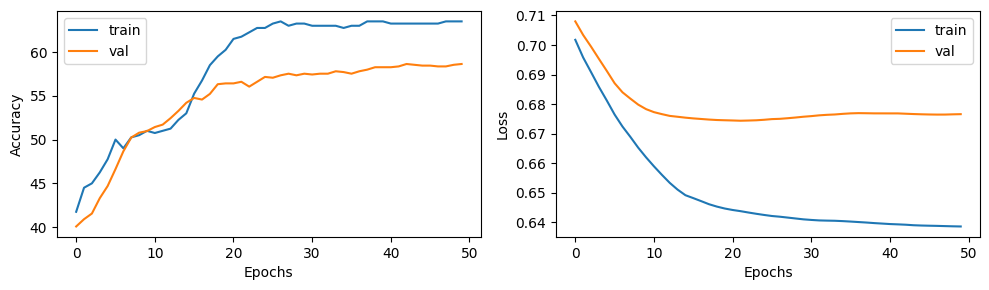

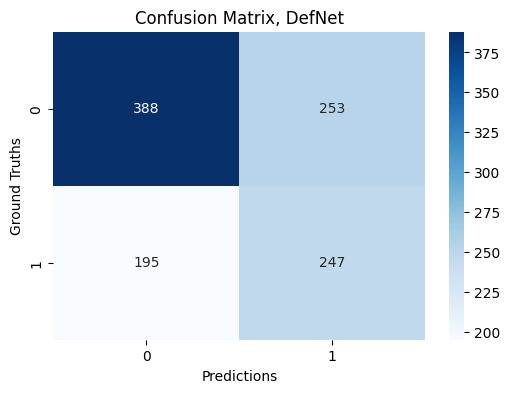

              precision    recall  f1-score   support

           0       0.67      0.61      0.63       641
           1       0.49      0.56      0.52       442

    accuracy                           0.59      1083
   macro avg       0.58      0.58      0.58      1083
weighted avg       0.60      0.59      0.59      1083



In [66]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
axes[0].plot(training_history['accuracy'], label='train')
axes[0].plot(validation_history['accuracy'], label='val')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(training_history['loss'], label='train')
axes[1].plot(validation_history['loss'], label='val')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
fig.tight_layout()

plt.show()

plot_confusion_matrix(small_net, val_loader, device)

Tau Threshold

In [67]:
model_path = fr'.\nets\compas\iter_{iter}\acc_t_models\16_8_acc_t_model_50.pt' 
small_net.load_state_dict(torch.load(model_path))
small_net.eval()

with torch.no_grad():
   probas= small_net.predict_proba_nn(X_val, device)
   y_pred= small_net.predict(X_val,device)

max_conf= probas.max(axis=1)

taus= np.linspace(0.50, 0.99, 50)
y_val_np= y_val.cpu().numpy() if torch.is_tensor(y_val) else np.array(y_val)

res= [evaluate_threshold(t, max_conf, y_pred, y_val_np) for t in taus]

best_tau = None
best_acc = -1
for tau, (acc_sel, cov, _) in zip(taus, res):
   if cov >= 0.6 and acc_sel > best_acc:
      best_acc = acc_sel 
      best_tau = tau


print(best_tau)
print(best_acc)


0.53
0.6132208157524613


##### Net 2: 32/16

tau= 0.52

In [75]:
# Log config changes:

# 1. dropout 0.3, lr= 0.001, weight decay 1e-3, step size 15, gamma 0.5, label smoothing 0.08, class weights 1.0 and 1.4
# 2. dropout 0.3, lr= 0.001, weight decay 5e-3, step size 15, gamma 0.5, label smoothing 0.1, class weights 1.0 and 1.2


set_all_seeds(42)

large_net= DeferralNet(input_size= 8, hidden_layer1= 32, hidden_layer2= 16, output_size=2, dropout_coeff=0.3)

large_net.to(device)

optimizer = optim.Adam(params=large_net.parameters(),
                       lr=0.001,
                       weight_decay= 5e-3

                    )

weights = torch.tensor([1.0, 1.2]).to(device)
criterion= nn.CrossEntropyLoss(weight=weights, label_smoothing=0.1)
scheduler = StepLR(optimizer, step_size=15, gamma=0.5) 


Training

Training Results - Epoch[1] Avg accuracy: 0.47 Avg loss: 0.70
Validation Results - Epoch[1] Avg accuracy: 0.49 Avg loss: 0.70
End of Epoch 1: Learning Rate 0.001
Training Results - Epoch[2] Avg accuracy: 0.48 Avg loss: 0.70
Validation Results - Epoch[2] Avg accuracy: 0.49 Avg loss: 0.70
End of Epoch 2: Learning Rate 0.001
Training Results - Epoch[3] Avg accuracy: 0.49 Avg loss: 0.69
Validation Results - Epoch[3] Avg accuracy: 0.49 Avg loss: 0.70
End of Epoch 3: Learning Rate 0.001
Training Results - Epoch[4] Avg accuracy: 0.51 Avg loss: 0.69
Validation Results - Epoch[4] Avg accuracy: 0.52 Avg loss: 0.70
End of Epoch 4: Learning Rate 0.001
Training Results - Epoch[5] Avg accuracy: 0.55 Avg loss: 0.69
Validation Results - Epoch[5] Avg accuracy: 0.53 Avg loss: 0.69
End of Epoch 5: Learning Rate 0.001
Training Results - Epoch[6] Avg accuracy: 0.56 Avg loss: 0.69
Validation Results - Epoch[6] Avg accuracy: 0.54 Avg loss: 0.69
End of Epoch 6: Learning Rate 0.001
Training Results - Epoch[7] 

2026-02-17 15:53:52,782 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


Validation Results - Epoch[26] Avg accuracy: 0.61 Avg loss: 0.68
End of Epoch 26: Learning Rate 0.0005
Training Results - Epoch[27] Avg accuracy: 0.69 Avg loss: 0.67
Validation Results - Epoch[27] Avg accuracy: 0.60 Avg loss: 0.68
End of Epoch 27: Learning Rate 0.0005


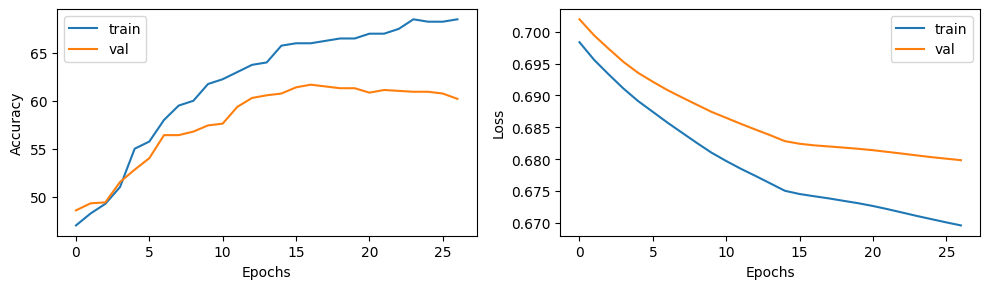

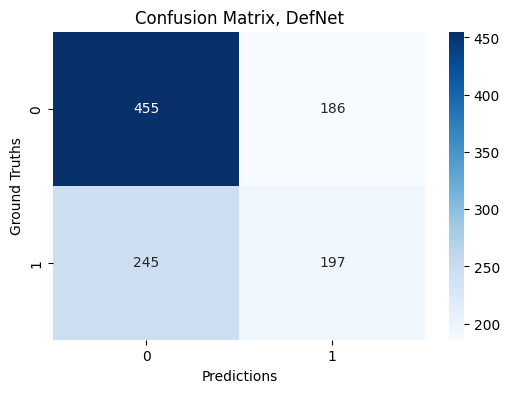

              precision    recall  f1-score   support

           0       0.65      0.71      0.68       641
           1       0.51      0.45      0.48       442

    accuracy                           0.60      1083
   macro avg       0.58      0.58      0.58      1083
weighted avg       0.59      0.60      0.60      1083



In [76]:
# Setting Ignite environment (preso direttamente da lab nn pytorch)

# ignite trainer
trainer = create_supervised_trainer(large_net, optimizer, criterion, device)

# validation e accuracy metrics are ignite metrics
training_history = {'accuracy':[],'loss':[]}
validation_history = {'accuracy':[],'loss':[]}
val_metrics = {"accuracy": Accuracy(), "loss": Loss(criterion)}

# ignite train and validation evaluators
train_evaluator = create_supervised_evaluator(large_net, metrics=val_metrics, device=device)
val_evaluator = create_supervised_evaluator(large_net, metrics=val_metrics, device=device)

# For logging purposes we add a function to be executed at the end of every log_interval-th iteration:
log_interval = 100

@trainer.on(Events.ITERATION_COMPLETED(every=log_interval))
def log_training_loss(engine):
    print(f"Epoch[{engine.state.epoch}], Iter[{engine.state.iteration}] Loss: {engine.state.output:.2f}")

# after a training epoch, computes training and validation metrics (train_eval on train_loader and val_eval on val_loader)
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(acc_t_loader)
    metrics = train_evaluator.state.metrics
    training_history['accuracy'].append(metrics['accuracy']*100)
    training_history['loss'].append(metrics['loss'])
    print(f"Training Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['loss']:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    val_evaluator.run(val_loader)
    metrics = val_evaluator.state.metrics
    validation_history['accuracy'].append(metrics['accuracy']*100)
    validation_history['loss'].append(metrics['loss'])
    print(f"Validation Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['loss']:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def update_lr_scheduler(trainer):
    scheduler.step()
    lr = optimizer.param_groups[0]['lr']
    print(f"End of Epoch {trainer.state.epoch}: Learning Rate {lr}")


# return current value of any metric defined in val_metrics
def score_function(engine):
    return engine.state.metrics["accuracy"]


# define early stopping and model checkpoint
handler = EarlyStopping(patience=10, score_function=score_function, trainer=trainer)

checkpoint = ModelCheckpoint(
    dirname=fr'nets\compas\iter_{iter}\acc_t_models',
    filename_prefix='32_16_acc_t',
    n_saved=1,
    create_dir=True,
    global_step_transform=global_step_from_engine(trainer), # helps fetch the trainer's state
    require_empty= False
)

# Attach early stopping and model checkpoint to the trainer
val_evaluator.add_event_handler(Events.EPOCH_COMPLETED, handler)
val_evaluator.add_event_handler(Events.EPOCH_COMPLETED, checkpoint, {'model': large_net})


trainer.run(acc_t_loader, max_epochs= 30 )



fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
axes[0].plot(training_history['accuracy'], label='train')
axes[0].plot(validation_history['accuracy'], label='val')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(training_history['loss'], label='train')
axes[1].plot(validation_history['loss'], label='val')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
fig.tight_layout()

plt.show()

plot_confusion_matrix(large_net, val_loader, device)

Tau Threshold

In [77]:
# dopo avere scelto la net migliore

model_path = fr'nets\compas\iter_{iter}\acc_t_models\32_16_acc_t_model_27.pt' 
large_net.load_state_dict(torch.load(model_path))
large_net.eval()

with torch.no_grad():
   probas= large_net.predict_proba_nn(X_val, device)
   y_pred= large_net.predict(X_val,device)

max_conf= probas.max(axis=1)

taus= np.linspace(0.50, 0.99, 50)
y_val_np= y_val.cpu().numpy() if torch.is_tensor(y_val) else np.array(y_val)

res= [evaluate_threshold(t, max_conf, y_pred, y_val_np) for t in taus]

best_tau = None
best_acc = -1
for tau, (acc_sel, cov, _) in zip(taus, res):
   if cov >= 0.6 and acc_sel > best_acc:
      best_acc = acc_sel 
      best_tau = tau


print(best_tau)
print(best_acc)



0.52
0.6524390243902439


#### Deferral Strat 2 



0.404082         0.6975         0.1725

0.412245         0.6550         0.0525
  
  65% accuracy not bad since the machine has never predicted actually and we defer only 5%

In [83]:
def_data = []
pred_correct = []
C = []
alpha = 1.0  
beta = 0.1


for idx, row in df_acc_t.iterrows():

    x_i = row[feat_order].values.tolist()
    #x_i = list(entry['dict_form'].values())
    
    # 1 se la macchina ha indovinato, 0 se ha sbagliato
    corr = 1.0 if row['machine prediction'] == row['ground truth'] else 0.0 # la ground truth originale
    
    # Costo di deferral C
    if row['provider'] == "H":
        c_i = beta # L'umano è stato scelto ed era utile
    else:
        c_i = alpha + beta # L'umano non è stato scelto, chiamarlo sarebbe un costo extra
    
    def_data.append(x_i)
    pred_correct.append(corr)
    C.append(c_i)

X_def = torch.tensor(def_data, dtype=torch.float32)
pred_correct = torch.tensor(pred_correct, dtype=torch.float32)
C = torch.tensor(C, dtype=torch.float32)

In [88]:
# sulla base di x_def chiamo la rete 
set_all_seeds(42)
r_net= DeferralNet(input_size=X_def.shape[1], hidden_layer1=16, hidden_layer2=8, output_size=1, dropout_coeff= 0.1)


optimizer = torch.optim.Adam(r_net.parameters(), lr=5e-4)
dataset = torch.utils.data.TensorDataset(X_def, pred_correct, C)
loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)


save_dir = fr'.\r_nets\compas\iter_{iter}'
os.makedirs(save_dir, exist_ok=True)

r_net.to(device)
r_net.train()

for epoch in range(20):
    running_loss = 0.0
    for xb, pc_b, c_b in loader:
      
        xb, pc_b, c_b = xb.to(device), pc_b.to(device), c_b.to(device)
        
        r_vals = r_net(xb).view(-1) # .view(-1) assicura che r sia un vettore piatto
    
        loss = deferral_loss(r_vals, pc_b, c_b)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    

    print(f"Epoch {epoch+1}/20 - Loss: {running_loss/len(loader):.4f}")
    
torch.save(r_net.state_dict(), os.path.join(save_dir, 'r_net_acc_t.pth'))
print("✅ r_net salvata correttamente in", save_dir)

Epoch 1/20 - Loss: 0.4427
Epoch 2/20 - Loss: 0.4421
Epoch 3/20 - Loss: 0.4423
Epoch 4/20 - Loss: 0.4298
Epoch 5/20 - Loss: 0.4373
Epoch 6/20 - Loss: 0.4335
Epoch 7/20 - Loss: 0.4309
Epoch 8/20 - Loss: 0.4280
Epoch 9/20 - Loss: 0.4226
Epoch 10/20 - Loss: 0.4269
Epoch 11/20 - Loss: 0.4098
Epoch 12/20 - Loss: 0.3993
Epoch 13/20 - Loss: 0.4080
Epoch 14/20 - Loss: 0.4070
Epoch 15/20 - Loss: 0.4005
Epoch 16/20 - Loss: 0.4084
Epoch 17/20 - Loss: 0.3955
Epoch 18/20 - Loss: 0.3897
Epoch 19/20 - Loss: 0.3942
Epoch 20/20 - Loss: 0.3893
✅ r_net salvata correttamente in .\r_nets\compas\iter_1


In [93]:
set_all_seeds(42)


p_defer_calib = p_defer(X_cal.to('cuda'), r_net).flatten()

#richiamo la net 
small_net= DeferralNet(input_size= 8, hidden_layer1= 16, hidden_layer2= 8, output_size=2, dropout_coeff=0.0)

net_path= fr".\nets\compas\iter_{iter}\acc_t_models\16_8_acc_t_model_50.pt"
small_net.load_state_dict(torch.load(net_path, map_location=device))
small_net.to(device)

y_h_calib = small_net.predict(X_cal.to('cuda'), device)
y_gt_calib = y_cal.numpy()

thresholds = np.linspace(0.2, 0.6, 50)
calibration_results = []

for tr in thresholds:
    
    defer_mask = (p_defer_calib >= tr)
    
    # accuracy custom, applichi mask + fetch correct
    correct_decisions = np.where(defer_mask, 1.0, (y_h_calib == y_gt_calib))
    team_acc = np.mean(correct_decisions)
    
    defer_rate = np.mean(defer_mask)
    
    calibration_results.append({
        'tau_r': tr,
        'team_accuracy': team_acc,
        'deferral_rate': defer_rate
    })

print(pd.DataFrame(calibration_results))

       tau_r  team_accuracy  deferral_rate
0   0.200000         1.0000         1.0000
1   0.208163         1.0000         1.0000
2   0.216327         1.0000         1.0000
3   0.224490         1.0000         1.0000
4   0.232653         1.0000         1.0000
5   0.240816         1.0000         1.0000
6   0.248980         1.0000         1.0000
7   0.257143         1.0000         1.0000
8   0.265306         1.0000         1.0000
9   0.273469         1.0000         0.9975
10  0.281633         1.0000         0.9950
11  0.289796         1.0000         0.9900
12  0.297959         1.0000         0.9825
13  0.306122         0.9975         0.9700
14  0.314286         0.9900         0.9525
15  0.322449         0.9900         0.9450
16  0.330612         0.9850         0.9225
17  0.338776         0.9700         0.8875
18  0.346939         0.9575         0.8475
19  0.355102         0.9400         0.8050
20  0.363265         0.9150         0.7425
21  0.371429         0.8900         0.6775
22  0.37959

### Iter 2

In [94]:
# retrieving the calibration split 
iter=2

df_val= pd.read_csv(fr".\processed_data\compas\calibration_datasets\iter_{iter}\acc_t_calibration.csv")
df_val= df_val.rename(columns={'did_recid': 'ground_truth'})  # per non confondermi


In [95]:
# retrieving data

df_acc_t = pd.read_csv(f".\processed_data\compas\hic_results_ds\iter_{iter}\hic_accurate_trusting.csv")

df_acc_t= df_acc_t.rename(columns={'did_recid':'g_truth'})  

path= f".\processed_data\compas\switch_ds\iter_{iter}"
os.makedirs(path, exist_ok=True)
file_path = os.path.join(path, f"acc_t_switch.csv")

df_acc_t.to_csv(file_path, index=False)


In [96]:
feat_order = [c for c in df_acc_t.columns if c not in [
    'did_recid', 'g_truth', 'ground truth', 
    'proba_model', 'provider', 'machine prediction', 'expert prediction','idx'
]]


X_cal = torch.tensor(df_acc_t[feat_order].values, dtype=torch.float32)
y_cal = torch.tensor(df_acc_t['g_truth'].values, dtype=torch.long)

acc_t_df = TensorDataset(X_cal, y_cal)
acc_t_loader = DataLoader(acc_t_df, batch_size=128, shuffle=False)

X_val = torch.tensor(df_val[feat_order].values, dtype=torch.float32)
y_val = torch.tensor(df_val['ground_truth'].values, dtype=torch.long)

val_d = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_d, batch_size=128, shuffle=False)

#### Deferral Strat 1


##### Net 1: 16/8

tau= 0.59

perfomance(benchmark) accuracy 64%

In [108]:
# Log config changes:
set_all_seeds(42)

# 1. dropout 0.3, lr= 0.003, weight decay 8e-3, step size 15, gamma 0.5, label smoothing 0.1, class weights 1.0 and 1.3
# meh 

# 2. dropout 0.3, lr= 0.003, weight decay 5e-3, step size 20, gamma 0.5, label smoothing 0.1, class weights 1.0 and 1.3



# aumentando troppo i pesi (già 1.3 sembra troppo) induce molta instabilità all'inizio, anche se ha risultati migliori non ne vale la pena

#overall con configurazioni affini a dropout 0.2, lr 0.001, weight decay 5e-3, label smoothing 0.05
# la rete non riesce a minimizzare affatto
# il label smoothing aumentato a 0.1 aiuta un po' di più perchè la loss non aumenta di moltissimo, 
# ma bisogna trovare il mix giusto per farla abbassare anche di poco

# nuova config: batch aumentata a 128 ciascuno, learning rate 0.003, weight decay 1e-2
# decay 5e-2 troppo aggressivo verso la classe 0, lets try 8e-3, altre condizioni uguali


small_net= DeferralNet(input_size=8, hidden_layer1= 16, hidden_layer2= 8, output_size=2, dropout_coeff=0.3)

small_net.to(device)

optimizer = optim.Adam(params=small_net.parameters(),
                       lr=0.003,
                       weight_decay= 1e-3
                    )

weights = torch.tensor([1.0, 1.35]).to(device) 

criterion= nn.CrossEntropyLoss(weight=weights, label_smoothing=0.1)
scheduler = StepLR(optimizer, step_size=20, gamma=0.5) 


Training

In [109]:
# Setting Ignite environment (preso direttamente da lab nn pytorch)

# ignite trainer
trainer = create_supervised_trainer(small_net, optimizer, criterion, device)

# validation e accuracy metrics are ignite metrics
training_history = {'accuracy':[],'loss':[]}
validation_history = {'accuracy':[],'loss':[]}
val_metrics = {"accuracy": Accuracy(), "loss": Loss(criterion)}

# ignite train and validation evaluators
train_evaluator = create_supervised_evaluator(small_net, metrics=val_metrics, device=device)
val_evaluator = create_supervised_evaluator(small_net, metrics=val_metrics, device=device)

# For logging purposes we add a function to be executed at the end of every log_interval-th iteration:
log_interval = 100

@trainer.on(Events.ITERATION_COMPLETED(every=log_interval))
def log_training_loss(engine):
    print(f"Epoch[{engine.state.epoch}], Iter[{engine.state.iteration}] Loss: {engine.state.output:.2f}")

# after a training epoch, computes training and validation metrics (train_eval on train_loader and val_eval on val_loader)
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(acc_t_loader)
    metrics = train_evaluator.state.metrics
    training_history['accuracy'].append(metrics['accuracy']*100)
    training_history['loss'].append(metrics['loss'])
    print(f"Training Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['loss']:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    val_evaluator.run(val_loader)
    metrics = val_evaluator.state.metrics
    validation_history['accuracy'].append(metrics['accuracy']*100)
    validation_history['loss'].append(metrics['loss'])
    print(f"Validation Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['loss']:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def update_lr_scheduler(trainer):
    scheduler.step()
    lr = optimizer.param_groups[0]['lr']
    print(f"End of Epoch {trainer.state.epoch}: Learning Rate {lr}")

# return current value of any metric defined in val_metrics
def score_function(engine):
    return engine.state.metrics["accuracy"]


# define early stopping and model checkpoint
handler = EarlyStopping(patience=30, score_function=score_function, trainer=trainer)

checkpoint = ModelCheckpoint(
    dirname=fr'nets\compas\iter_{iter}\acc_t_models',
    filename_prefix='16_8_acc_t',
    n_saved=1,
    create_dir=True,
    require_empty=False,
    global_step_transform=global_step_from_engine(trainer) # helps fetch the trainer's state
)

# Attach early stopping and model checkpoint to the trainer
val_evaluator.add_event_handler(Events.EPOCH_COMPLETED, handler)
val_evaluator.add_event_handler(Events.EPOCH_COMPLETED, checkpoint, {'model': small_net})


trainer.run(acc_t_loader, max_epochs= 30)

Training Results - Epoch[1] Avg accuracy: 0.46 Avg loss: 0.69
Validation Results - Epoch[1] Avg accuracy: 0.41 Avg loss: 0.71
End of Epoch 1: Learning Rate 0.003
Training Results - Epoch[2] Avg accuracy: 0.46 Avg loss: 0.67
Validation Results - Epoch[2] Avg accuracy: 0.41 Avg loss: 0.70
End of Epoch 2: Learning Rate 0.003
Training Results - Epoch[3] Avg accuracy: 0.46 Avg loss: 0.66
Validation Results - Epoch[3] Avg accuracy: 0.41 Avg loss: 0.69
End of Epoch 3: Learning Rate 0.003
Training Results - Epoch[4] Avg accuracy: 0.46 Avg loss: 0.64
Validation Results - Epoch[4] Avg accuracy: 0.41 Avg loss: 0.69
End of Epoch 4: Learning Rate 0.003
Training Results - Epoch[5] Avg accuracy: 0.48 Avg loss: 0.63
Validation Results - Epoch[5] Avg accuracy: 0.46 Avg loss: 0.68
End of Epoch 5: Learning Rate 0.003
Training Results - Epoch[6] Avg accuracy: 0.65 Avg loss: 0.62
Validation Results - Epoch[6] Avg accuracy: 0.52 Avg loss: 0.68
End of Epoch 6: Learning Rate 0.003
Training Results - Epoch[7] 

State:
	iteration: 300
	epoch: 30
	epoch_length: 10
	max_epochs: 30
	output: 0.7156751751899719
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

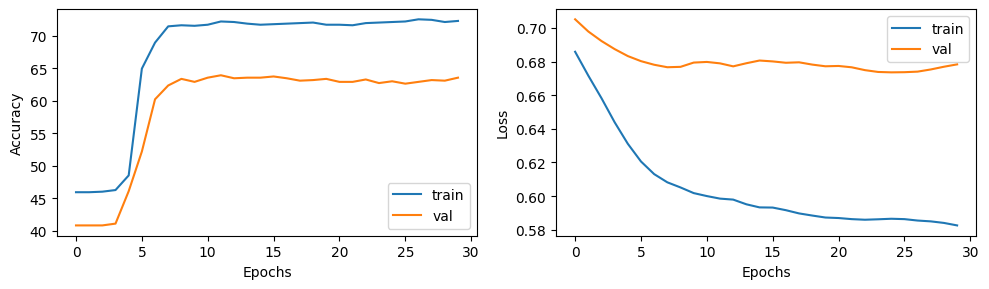

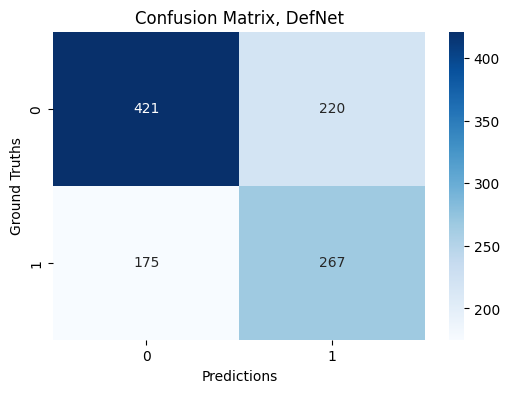

              precision    recall  f1-score   support

           0       0.71      0.66      0.68       641
           1       0.55      0.60      0.57       442

    accuracy                           0.64      1083
   macro avg       0.63      0.63      0.63      1083
weighted avg       0.64      0.64      0.64      1083



In [110]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
axes[0].plot(training_history['accuracy'], label='train')
axes[0].plot(validation_history['accuracy'], label='val')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(training_history['loss'], label='train')
axes[1].plot(validation_history['loss'], label='val')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
fig.tight_layout()

plt.show()

plot_confusion_matrix(small_net, val_loader, device)

Tau Threshold

In [112]:
model_path = fr'.\nets\compas\iter_{iter}\acc_t_models\16_8_acc_t_model_30.pt' 

small_net.load_state_dict(torch.load(model_path))
small_net.eval()

with torch.no_grad():
   probas= small_net.predict_proba_nn(X_val, device)
   y_pred= small_net.predict(X_val,device)

max_conf= probas.max(axis=1)

taus= np.linspace(0.50, 0.99, 50)
y_val_np= y_val.cpu().numpy() if torch.is_tensor(y_val) else np.array(y_val)

res= [evaluate_threshold(t, max_conf, y_pred, y_val_np) for t in taus]

best_tau = None
best_acc = -1
for tau, (acc_sel, cov, _) in zip(taus, res):
   if cov >= 0.6 and acc_sel > best_acc:
      best_acc = acc_sel 
      best_tau = tau


print(best_tau)
print(best_acc)


0.59
0.6799387442572741


##### Net 2: 32/16

DA QUI IN POI

In [68]:
## instantiating the Deferral Net structures + Dropout rate 0.2 e Early Stopping

large_net= DeferralNet(input_size=8, hidden_layer1= 16, hidden_layer2= 8, output_size=2, dropout_coeff=0.3)

large_net.to(device)

optimizer = optim.Adam(params=large_net.parameters(),
                       lr=0.003,
                       weight_decay= 8e-3

                    )

weights = torch.tensor([1.0, 1.3]).to(device) 

criterion= nn.CrossEntropyLoss(weight=weights, label_smoothing=0.1)
scheduler = StepLR(optimizer, step_size=15, gamma=0.5) 


Training

Training Results - Epoch[1] Avg accuracy: 0.50 Avg loss: 0.66
Validation Results - Epoch[1] Avg accuracy: 0.42 Avg loss: 0.69
End of Epoch 1: Learning Rate 0.003
Training Results - Epoch[2] Avg accuracy: 0.53 Avg loss: 0.65
Validation Results - Epoch[2] Avg accuracy: 0.49 Avg loss: 0.68
End of Epoch 2: Learning Rate 0.003
Training Results - Epoch[3] Avg accuracy: 0.56 Avg loss: 0.64
Validation Results - Epoch[3] Avg accuracy: 0.55 Avg loss: 0.68
End of Epoch 3: Learning Rate 0.003
Training Results - Epoch[4] Avg accuracy: 0.61 Avg loss: 0.63
Validation Results - Epoch[4] Avg accuracy: 0.59 Avg loss: 0.68
End of Epoch 4: Learning Rate 0.003
Training Results - Epoch[5] Avg accuracy: 0.67 Avg loss: 0.61
Validation Results - Epoch[5] Avg accuracy: 0.61 Avg loss: 0.68
End of Epoch 5: Learning Rate 0.003
Training Results - Epoch[6] Avg accuracy: 0.70 Avg loss: 0.60
Validation Results - Epoch[6] Avg accuracy: 0.61 Avg loss: 0.68
End of Epoch 6: Learning Rate 0.003
Training Results - Epoch[7] 

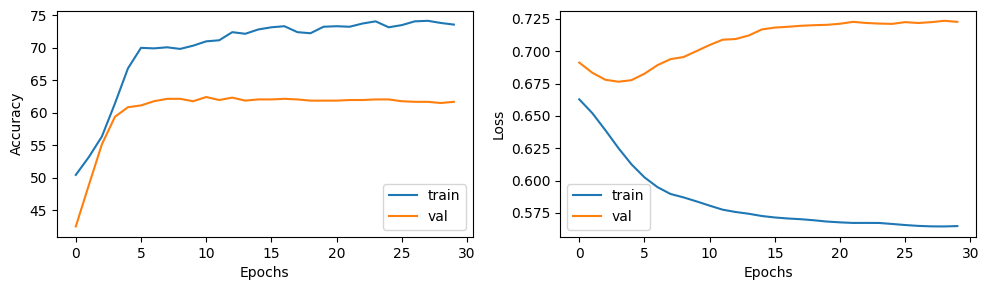

In [69]:
# Setting Ignite environment (preso direttamente da lab nn pytorch)

# ignite trainer
trainer = create_supervised_trainer(large_net, optimizer, criterion, device)

# validation e accuracy metrics are ignite metrics
training_history = {'accuracy':[],'loss':[]}
validation_history = {'accuracy':[],'loss':[]}
val_metrics = {"accuracy": Accuracy(), "loss": Loss(criterion)}

# ignite train and validation evaluators
train_evaluator = create_supervised_evaluator(large_net, metrics=val_metrics, device=device)
val_evaluator = create_supervised_evaluator(large_net, metrics=val_metrics, device=device)

# For logging purposes we add a function to be executed at the end of every log_interval-th iteration:
log_interval = 100

@trainer.on(Events.ITERATION_COMPLETED(every=log_interval))
def log_training_loss(engine):
    print(f"Epoch[{engine.state.epoch}], Iter[{engine.state.iteration}] Loss: {engine.state.output:.2f}")

# after a training epoch, computes training and validation metrics (train_eval on train_loader and val_eval on val_loader)
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(acc_t_loader)
    metrics = train_evaluator.state.metrics
    training_history['accuracy'].append(metrics['accuracy']*100)
    training_history['loss'].append(metrics['loss'])
    print(f"Training Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['loss']:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    val_evaluator.run(val_loader)
    metrics = val_evaluator.state.metrics
    validation_history['accuracy'].append(metrics['accuracy']*100)
    validation_history['loss'].append(metrics['loss'])
    print(f"Validation Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['loss']:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def update_lr_scheduler(trainer):
    scheduler.step()
    lr = optimizer.param_groups[0]['lr']
    print(f"End of Epoch {trainer.state.epoch}: Learning Rate {lr}")


# return current value of any metric defined in val_metrics
def score_function(engine):
    return engine.state.metrics["accuracy"]


# define early stopping and model checkpoint
handler = EarlyStopping(patience=30, score_function=score_function, trainer=trainer)

checkpoint = ModelCheckpoint(
    dirname=fr'nets\compas\acc_t_models\iter_{iter}',
    filename_prefix='32_16_acc_t',
    n_saved=1,
    create_dir=True,
    global_step_transform=global_step_from_engine(trainer), # helps fetch the trainer's state
    require_empty= False
)

# Attach early stopping and model checkpoint to the trainer
val_evaluator.add_event_handler(Events.EPOCH_COMPLETED, handler)
val_evaluator.add_event_handler(Events.EPOCH_COMPLETED, checkpoint, {'model': large_net})


trainer.run(acc_t_loader, max_epochs= 30 )



fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
axes[0].plot(training_history['accuracy'], label='train')
axes[0].plot(validation_history['accuracy'], label='val')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(training_history['loss'], label='train')
axes[1].plot(validation_history['loss'], label='val')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
fig.tight_layout()

plt.show()

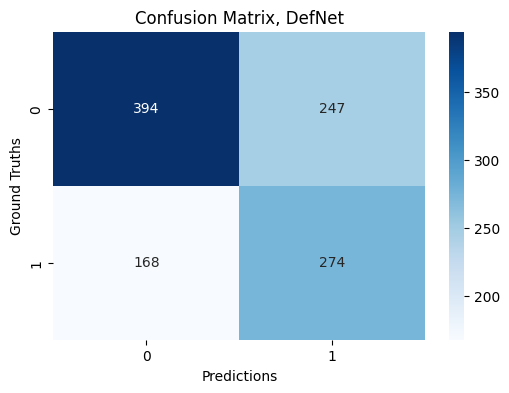

              precision    recall  f1-score   support

           0       0.70      0.61      0.66       641
           1       0.53      0.62      0.57       442

    accuracy                           0.62      1083
   macro avg       0.61      0.62      0.61      1083
weighted avg       0.63      0.62      0.62      1083



In [70]:
plot_confusion_matrix(large_net, val_loader, device)

Tau Threshold

In [72]:
# dopo avere scelto la net migliore

model_path = fr'.\nets\compas\acc_t_models\iter_{iter}\32_16_acc_t_model_30.pt'
large_net.load_state_dict(torch.load(model_path))
large_net.eval()

with torch.no_grad():
   probas= large_net.predict_proba_nn(X_val, device)
   y_pred= large_net.predict(X_val,device)

max_conf= probas.max(axis=1)

taus= np.linspace(0.50, 0.99, 50)
y_val_np= y_val.cpu().numpy() if torch.is_tensor(y_val) else np.array(y_val)

res= [evaluate_threshold(t, max_conf, y_pred, y_val_np) for t in taus]

best_tau = None
best_acc = -1
for tau, (acc_sel, cov, _) in zip(taus, res):
   if cov >= 0.6 and acc_sel > best_acc:
      best_acc = acc_sel 
      best_tau = tau


print(best_tau)
print(best_acc)



0.64
0.6701649175412294


#### Deferral Strat 2 


0.528571       0.769167       0.073333 <-- this one not bad at all

0.536735       0.755833       0.015000 

77% accuracy, 7% deferred

In [73]:
def_data = []
pred_correct = []
C = []
alpha = 1.0  
beta = 0.1


for idx, row in df_acc_t.iterrows():

    x_i = row[feat_order].values.tolist()
    #x_i = list(entry['dict_form'].values())
    
    # 1 se la macchina ha indovinato, 0 se ha sbagliato
    corr = 1.0 if row['machine prediction'] == row['ground truth'] else 0.0 # la ground truth originale
    
    # Costo di deferral C
    if row['provider'] == "H":
        c_i = beta # L'umano è stato scelto ed era utile
    else:
        c_i = alpha + beta # L'umano non è stato scelto, chiamarlo sarebbe un costo extra
    
    def_data.append(x_i)
    pred_correct.append(corr)
    C.append(c_i)

X_def = torch.tensor(def_data, dtype=torch.float32)
pred_correct = torch.tensor(pred_correct, dtype=torch.float32)
C = torch.tensor(C, dtype=torch.float32)

In [74]:
# sulla base di x_def chiamo la rete 

r_net= DeferralNet(input_size=X_def.shape[1], hidden_layer1=16, hidden_layer2=8, output_size=1, dropout_coeff= 0.0)


optimizer = torch.optim.Adam(r_net.parameters(), lr=1e-4)
dataset = torch.utils.data.TensorDataset(X_def, pred_correct, C)
loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

In [75]:
save_dir = fr'.\r_nets\compas\iter_{iter}'
os.makedirs(save_dir, exist_ok=True)

r_net.to(device)
r_net.train()

for epoch in range(20):
    running_loss = 0.0
    for xb, pc_b, c_b in loader:
      
        xb, pc_b, c_b = xb.to(device), pc_b.to(device), c_b.to(device)
        
        r_vals = r_net(xb).view(-1) # .view(-1) assicura che r sia un vettore piatto
    
        loss = deferral_loss(r_vals, pc_b, c_b)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    

    print(f"Epoch {epoch+1}/20 - Loss: {running_loss/len(loader):.4f}")
    
torch.save(r_net.state_dict(), os.path.join(save_dir, 'r_net_acc_t.pth'))
print("✅ r_net salvata correttamente in", save_dir)

Epoch 1/20 - Loss: 0.5488
Epoch 2/20 - Loss: 0.5491
Epoch 3/20 - Loss: 0.5458
Epoch 4/20 - Loss: 0.5453
Epoch 5/20 - Loss: 0.5461
Epoch 6/20 - Loss: 0.5365
Epoch 7/20 - Loss: 0.5347
Epoch 8/20 - Loss: 0.5344
Epoch 9/20 - Loss: 0.5326
Epoch 10/20 - Loss: 0.5376
Epoch 11/20 - Loss: 0.5366
Epoch 12/20 - Loss: 0.5323
Epoch 13/20 - Loss: 0.5290
Epoch 14/20 - Loss: 0.5232
Epoch 15/20 - Loss: 0.5206
Epoch 16/20 - Loss: 0.5194
Epoch 17/20 - Loss: 0.5220
Epoch 18/20 - Loss: 0.5195
Epoch 19/20 - Loss: 0.5176
Epoch 20/20 - Loss: 0.5156
✅ r_net salvata correttamente in .\r_nets\compas\iter_2


In [78]:
p_defer_calib = p_defer(X_cal.to('cuda'), r_net).flatten()

#richiamo la net 
large_net= DeferralNet(input_size= 8, hidden_layer1= 16, hidden_layer2= 8, output_size=2, dropout_coeff=0.0)

net_path= fr".\nets\compas\acc_t_models\iter_{iter}\16_8_acc_t_model_30.pt"
large_net.load_state_dict(torch.load(net_path, map_location=device))
large_net.to(device)

y_h_calib = large_net.predict(X_cal.to('cuda'), device)
y_gt_calib = y_cal.numpy()

thresholds = np.linspace(0.3, 0.7, 50)
calibration_results = []

for tr in thresholds:
    # Maschera di chi viene mandato all'umano
    defer_mask = (p_defer_calib >= tr)
    
    # ACCURATEZZA TEAM:
    # Se defer_mask è True (H), diamo 1 (assumiamo che l'umano indovini)
    # Se defer_mask è False (M), verifichiamo se h ha indovinato il target vero
    correct_decisions = np.where(defer_mask, 1.0, (y_h_calib == y_gt_calib))
    team_acc = np.mean(correct_decisions)
    
    # Tasso di Deferral: quante istanze la r_net ha "scartato"
    defer_rate = np.mean(defer_mask)
    
    calibration_results.append({
        'tau_r': tr,
        'team_accuracy': team_acc,
        'deferral_rate': defer_rate
    })

print(pd.DataFrame(calibration_results))

       tau_r  team_accuracy  deferral_rate
0   0.300000       1.000000       0.998333
1   0.308163       1.000000       0.997500
2   0.316327       1.000000       0.997500
3   0.324490       1.000000       0.997500
4   0.332653       1.000000       0.996667
5   0.340816       1.000000       0.995833
6   0.348980       1.000000       0.995000
7   0.357143       1.000000       0.994167
8   0.365306       1.000000       0.993333
9   0.373469       1.000000       0.993333
10  0.381633       1.000000       0.993333
11  0.389796       1.000000       0.993333
12  0.397959       1.000000       0.993333
13  0.406122       1.000000       0.993333
14  0.414286       1.000000       0.993333
15  0.422449       1.000000       0.990000
16  0.430612       1.000000       0.988333
17  0.438776       1.000000       0.988333
18  0.446939       1.000000       0.988333
19  0.455102       1.000000       0.988333
20  0.463265       1.000000       0.982500
21  0.471429       1.000000       0.966667
22  0.47959

# Altri user

## Expert: Inaccurate, Trusting

In [39]:
# retrieving the calibration split 

df_val= pd.read_csv(r".\processed_data\compas\calibration_datasets\inacc_t_calibration")
df_val= df_val.rename(columns={'did_recid': 'ground_truth'})  # per non confondermi


In [40]:
# dropping irrelevant feat + renaming the decision column as 'ground truth' 
df_inacc_t= pd.read_csv(r".\processed_data\compas\hic_results_ds\hic_inaccurate_trusting")

df_inacc_t= df_inacc_t.rename(columns={'did_recid':'g_truth'})  

df_inacc_t.to_csv(r".\processed_data\compas\switch_ds\inacc_t_switch", index= False) # questa versione di df è quella che viene passata a start Mic come df switch


In [41]:
feat_order = [c for c in df_inacc_t.columns if c not in [
    'did_recid', 'g_truth', 'ground truth', 
    'proba_model', 'provider', 'machine prediction', 'expert prediction'
]]

X_cal = torch.tensor(df_inacc_t[feat_order].values, dtype=torch.float32)
y_cal = torch.tensor(df_inacc_t['g_truth'].values, dtype=torch.long)

inacc_t_df = TensorDataset(X_cal, y_cal)
inacc_t_loader = DataLoader(inacc_t_df, batch_size=64, shuffle=False)

X_val = torch.tensor(df_val[feat_order].values, dtype=torch.float32)
y_val = torch.tensor(df_val['ground_truth'].values, dtype=torch.long)

val_d = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_d, batch_size=64, shuffle=False)

### Strat 1


#### Net 1
tau 0.5700000000000001

In [42]:
## instantiating the Deferral Net structures + Dropout rate 0.2 e Early Stopping

small_net= DeferralNet(input_size=8, hidden_layer1= 16, hidden_layer2= 8, output_size=2, dropout_coeff=0.2)

small_net.to(device)

optimizer = optim.Adam(params=small_net.parameters(), 
                       lr=0.0005,
                       weight_decay= 1e-3
                    )


weights = torch.tensor([1.0, 1.3]).to(device)
criterion= nn.CrossEntropyLoss(weight=weights, label_smoothing=0.1)

scheduler = StepLR(optimizer, step_size=8, gamma=0.5)


##### Training

In [43]:
# Setting Ignite environment (preso direttamente da lab nn pytorch)

# ignite trainer
trainer = create_supervised_trainer(small_net, optimizer, criterion, device)

# validation e accuracy metrics are ignite metrics
training_history = {'accuracy':[],'loss':[]}
validation_history = {'accuracy':[],'loss':[]}
val_metrics = {"accuracy": Accuracy(), "loss": Loss(criterion)}

# ignite train and validation evaluators
train_evaluator = create_supervised_evaluator(small_net, metrics=val_metrics, device=device)
val_evaluator = create_supervised_evaluator(small_net, metrics=val_metrics, device=device)

# For logging purposes we add a function to be executed at the end of every log_interval-th iteration:
log_interval = 100

@trainer.on(Events.ITERATION_COMPLETED(every=log_interval))
def log_training_loss(engine):
    print(f"Epoch[{engine.state.epoch}], Iter[{engine.state.iteration}] Loss: {engine.state.output:.2f}")

# after a training epoch, computes training and validation metrics (train_eval on train_loader and val_eval on val_loader)
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(inacc_t_loader)
    metrics = train_evaluator.state.metrics
    training_history['accuracy'].append(metrics['accuracy']*100)
    training_history['loss'].append(metrics['loss'])
    print(f"Training Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['loss']:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    val_evaluator.run(val_loader)
    metrics = val_evaluator.state.metrics
    validation_history['accuracy'].append(metrics['accuracy']*100)
    validation_history['loss'].append(metrics['loss'])
    print(f"Validation Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['loss']:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def update_lr_scheduler(trainer):
    scheduler.step()
    lr = optimizer.param_groups[0]['lr']
    print(f"End of Epoch {trainer.state.epoch}: Learning Rate {lr}")

# return current value of any metric defined in val_metrics
def score_function(engine):
    return engine.state.metrics["accuracy"]


# define early stopping and model checkpoint
handler = EarlyStopping(patience=15, score_function=score_function, trainer=trainer)

checkpoint = ModelCheckpoint(
    dirname=r'.\nets\compas\inacc_t_models',
    filename_prefix='16_8',
    n_saved=1,
    create_dir=True,
    require_empty=False,
    global_step_transform=global_step_from_engine(trainer) # helps fetch the trainer's state
)

# Attach early stopping and model checkpoint to the trainer
val_evaluator.add_event_handler(Events.EPOCH_COMPLETED, handler)
val_evaluator.add_event_handler(Events.EPOCH_COMPLETED, checkpoint, {'model': small_net})


trainer.run(inacc_t_loader, max_epochs= 30)

Training Results - Epoch[1] Avg accuracy: 0.50 Avg loss: 0.70
Validation Results - Epoch[1] Avg accuracy: 0.40 Avg loss: 0.72
End of Epoch 1: Learning Rate 0.0005
Training Results - Epoch[2] Avg accuracy: 0.58 Avg loss: 0.67
Validation Results - Epoch[2] Avg accuracy: 0.39 Avg loss: 0.71
End of Epoch 2: Learning Rate 0.0005
Epoch[3], Iter[100] Loss: 0.62
Training Results - Epoch[3] Avg accuracy: 0.61 Avg loss: 0.65
Validation Results - Epoch[3] Avg accuracy: 0.41 Avg loss: 0.71
End of Epoch 3: Learning Rate 0.0005
Training Results - Epoch[4] Avg accuracy: 0.62 Avg loss: 0.63
Validation Results - Epoch[4] Avg accuracy: 0.41 Avg loss: 0.72
End of Epoch 4: Learning Rate 0.0005
Training Results - Epoch[5] Avg accuracy: 0.62 Avg loss: 0.61
Validation Results - Epoch[5] Avg accuracy: 0.41 Avg loss: 0.72
End of Epoch 5: Learning Rate 0.0005
Epoch[6], Iter[200] Loss: 0.60
Training Results - Epoch[6] Avg accuracy: 0.63 Avg loss: 0.60
Validation Results - Epoch[6] Avg accuracy: 0.42 Avg loss: 0.

State:
	iteration: 1020
	epoch: 30
	epoch_length: 34
	max_epochs: 30
	output: 0.6017767190933228
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

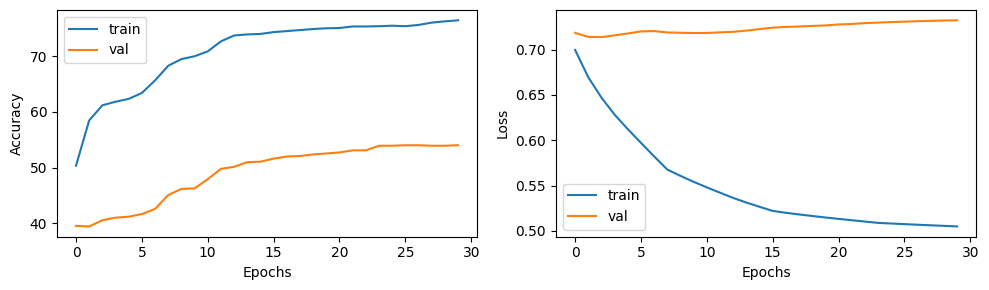

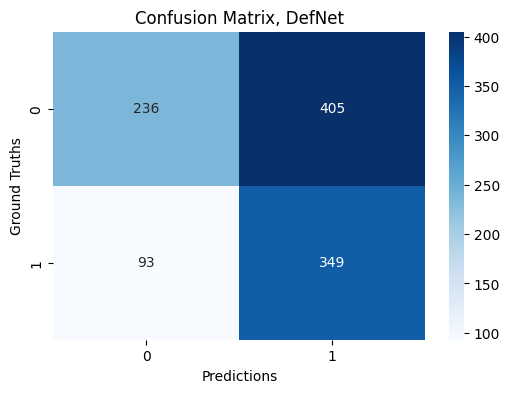

              precision    recall  f1-score   support

           0       0.72      0.37      0.49       641
           1       0.46      0.79      0.58       442

    accuracy                           0.54      1083
   macro avg       0.59      0.58      0.54      1083
weighted avg       0.61      0.54      0.53      1083



In [44]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
axes[0].plot(training_history['accuracy'], label='train')
axes[0].plot(validation_history['accuracy'], label='val')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(training_history['loss'], label='train')
axes[1].plot(validation_history['loss'], label='val')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
fig.tight_layout()

plt.show()

plot_confusion_matrix(small_net, val_loader, device)

##### Tau Threshold

In [45]:
# dopo avere scelto la net migliore

model_path = r'nets\compas\inacc_t_models\16_8_model_30.pt' 
small_net.load_state_dict(torch.load(model_path))
small_net.eval()

with torch.no_grad():
   probas= small_net.predict_proba_nn(X_val, device)
   y_pred= small_net.predict(X_val,device)

max_conf= probas.max(axis=1)

taus= np.linspace(0.50, 0.99, 50)
y_val_np= y_val.cpu().numpy() if torch.is_tensor(y_val) else np.array(y_val)

res= [evaluate_threshold(t, max_conf, y_pred, y_val_np) for t in taus]

best_tau = None
best_acc = -1
for tau, (acc_sel, cov, _) in zip(taus, res):
   if cov >= 0.6 and acc_sel > best_acc:
      best_acc = acc_sel 
      best_tau = tau


print(best_tau)
print(best_acc)


0.5700000000000001
0.5450180072028812


#### Net 2: 32/16

tau= 0.63

In [46]:
## instantiating the Deferral Net structures + Dropout rate 0.2 e Early Stopping

large_net= DeferralNet(input_size= 8, hidden_layer1= 32, hidden_layer2= 16, output_size=2, dropout_coeff=0.2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
large_net.to(device)

optimizer = optim.Adam(params=large_net.parameters(), 
                       lr=0.0005,
                       weight_decay= 1e-3
                    )

weights = torch.tensor([1.0, 1.3]).to(device)
criterion= nn.CrossEntropyLoss(weight=weights, label_smoothing=0.1)

scheduler = StepLR(optimizer, step_size=8, gamma=0.5)


##### Training

Training Results - Epoch[1] Avg accuracy: 0.61 Avg loss: 0.64
Validation Results - Epoch[1] Avg accuracy: 0.41 Avg loss: 0.70
End of Epoch 1: Learning Rate 0.0005
Training Results - Epoch[2] Avg accuracy: 0.62 Avg loss: 0.61
Validation Results - Epoch[2] Avg accuracy: 0.41 Avg loss: 0.70
End of Epoch 2: Learning Rate 0.0005
Epoch[3], Iter[100] Loss: 0.50
Training Results - Epoch[3] Avg accuracy: 0.62 Avg loss: 0.57
Validation Results - Epoch[3] Avg accuracy: 0.41 Avg loss: 0.72
End of Epoch 3: Learning Rate 0.0005
Training Results - Epoch[4] Avg accuracy: 0.64 Avg loss: 0.55
Validation Results - Epoch[4] Avg accuracy: 0.42 Avg loss: 0.73
End of Epoch 4: Learning Rate 0.0005
Training Results - Epoch[5] Avg accuracy: 0.69 Avg loss: 0.53
Validation Results - Epoch[5] Avg accuracy: 0.46 Avg loss: 0.74
End of Epoch 5: Learning Rate 0.0005
Epoch[6], Iter[200] Loss: 0.52
Training Results - Epoch[6] Avg accuracy: 0.73 Avg loss: 0.51
Validation Results - Epoch[6] Avg accuracy: 0.52 Avg loss: 0.

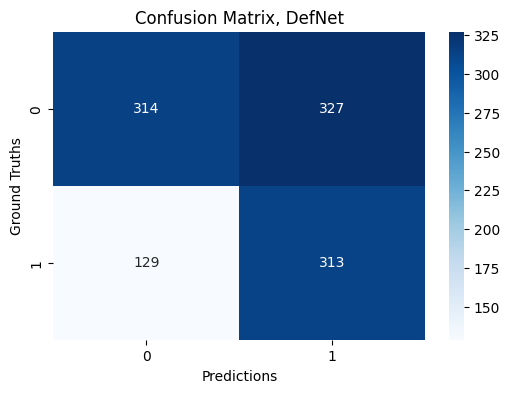

              precision    recall  f1-score   support

           0       0.71      0.49      0.58       641
           1       0.49      0.71      0.58       442

    accuracy                           0.58      1083
   macro avg       0.60      0.60      0.58      1083
weighted avg       0.62      0.58      0.58      1083



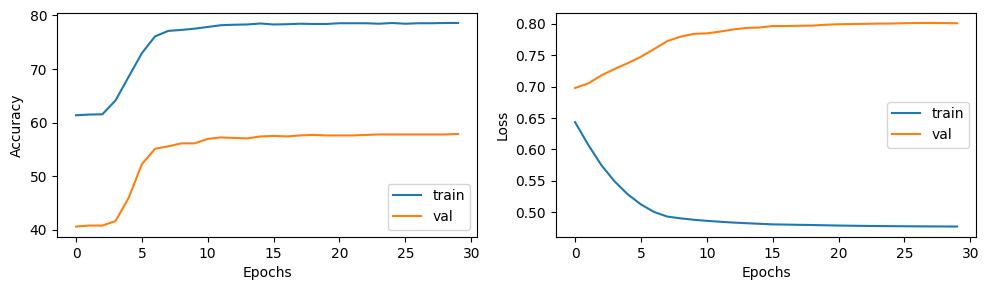

In [47]:
# Setting Ignite environment (preso direttamente da lab nn pytorch)

# ignite trainer
trainer = create_supervised_trainer(large_net, optimizer, criterion, device)

# validation e accuracy metrics are ignite metrics
training_history = {'accuracy':[],'loss':[]}
validation_history = {'accuracy':[],'loss':[]}
val_metrics = {"accuracy": Accuracy(), "loss": Loss(criterion)}

# ignite train and validation evaluators
train_evaluator = create_supervised_evaluator(large_net, metrics=val_metrics, device=device)
val_evaluator = create_supervised_evaluator(large_net, metrics=val_metrics, device=device)

# For logging purposes we add a function to be executed at the end of every log_interval-th iteration:
log_interval = 100

@trainer.on(Events.ITERATION_COMPLETED(every=log_interval))
def log_training_loss(engine):
    print(f"Epoch[{engine.state.epoch}], Iter[{engine.state.iteration}] Loss: {engine.state.output:.2f}")

# after a training epoch, computes training and validation metrics (train_eval on train_loader and val_eval on val_loader)
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(inacc_t_loader)
    metrics = train_evaluator.state.metrics
    training_history['accuracy'].append(metrics['accuracy']*100)
    training_history['loss'].append(metrics['loss'])
    print(f"Training Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['loss']:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    val_evaluator.run(val_loader)
    metrics = val_evaluator.state.metrics
    validation_history['accuracy'].append(metrics['accuracy']*100)
    validation_history['loss'].append(metrics['loss'])
    print(f"Validation Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['loss']:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def update_lr_scheduler(trainer):
    scheduler.step()
    lr = optimizer.param_groups[0]['lr']
    print(f"End of Epoch {trainer.state.epoch}: Learning Rate {lr}")

# return current value of any metric defined in val_metrics
def score_function(engine):
    return engine.state.metrics["accuracy"]


# define early stopping and model checkpoint
handler = EarlyStopping(patience=10, score_function=score_function, trainer=trainer)

checkpoint = ModelCheckpoint(
    dirname=r'.\nets\compas\inacc_t_models',
    filename_prefix='32_16',
    n_saved=1,
    create_dir=True,
    require_empty=False,
    global_step_transform=global_step_from_engine(trainer) # helps fetch the trainer's state
)

# Attach early stopping and model checkpoint to the trainer
val_evaluator.add_event_handler(Events.EPOCH_COMPLETED, handler)
val_evaluator.add_event_handler(Events.EPOCH_COMPLETED, checkpoint, {'model': large_net})


trainer.run(inacc_t_loader, max_epochs= 30)

plot_confusion_matrix(large_net, val_loader, device)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
axes[0].plot(training_history['accuracy'], label='train')
axes[0].plot(validation_history['accuracy'], label='val')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(training_history['loss'], label='train')
axes[1].plot(validation_history['loss'], label='val')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
fig.tight_layout()

plt.show()

##### Tau Threshold

In [48]:
# dopo avere scelto la net migliore
model_path = r'nets\compas\inacc_t_models\32_16_model_30.pt' 
large_net.load_state_dict(torch.load(model_path))
large_net.eval()

with torch.no_grad():
   probas= large_net.predict_proba_nn(X_val, device)
   y_pred= large_net.predict(X_val,device)

max_conf= probas.max(axis=1)

taus= np.linspace(0.50, 0.99, 50)
y_val_np= y_val.cpu().numpy() if torch.is_tensor(y_val) else np.array(y_val)

res= [evaluate_threshold(t, max_conf, y_pred, y_val_np) for t in taus]

best_tau = None
best_acc = -1
for tau, (acc_sel, cov, _) in zip(taus, res):
   if cov >= 0.6 and acc_sel > best_acc:
      best_acc = acc_sel 
      best_tau = tau


print(best_tau)
print(best_acc)



0.63
0.5858585858585859


### Deferral Strat 2 (anqi mao style)

i papabili

tau r            acc           def rate

0.183673       0.700969       0.031380

In [78]:
def_data = []
pred_correct = []
C = []
alpha = 1.0  
beta = 0.1


for idx, row in df_inacc_t.iterrows():

    x_i = row[feat_order].values.tolist()
    #x_i = list(entry['dict_form'].values())
    
    # 1 se la macchina ha indovinato, 0 se ha sbagliato
    corr = 1.0 if row['machine prediction'] == row['ground truth'] else 0.0 # la ground truth originale
    
    # Costo di deferral C
    if row['provider'] == "H":
        c_i = beta # L'umano è stato scelto ed era utile
    else:
        c_i = alpha + beta # L'umano non è stato scelto, chiamarlo sarebbe un costo extra
    
    def_data.append(x_i)
    pred_correct.append(corr)
    C.append(c_i)

X_def = torch.tensor(def_data, dtype=torch.float32)
pred_correct = torch.tensor(pred_correct, dtype=torch.float32)
C = torch.tensor(C, dtype=torch.float32)


In [79]:
# sulla base di x_def chiamo la rete 

r_net= DeferralNet(input_size=X_def.shape[1], hidden_layer1=16, hidden_layer2=8, output_size=1, dropout_coeff= 0.2)


optimizer = torch.optim.Adam(r_net.parameters(), lr=1e-3)
dataset = torch.utils.data.TensorDataset(X_def, pred_correct, C)
loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
r_net.to(device)
r_net.train()

for epoch in range(20):
    running_loss = 0.0
    for xb, pc_b, c_b in loader:
      
        xb, pc_b, c_b = xb.to(device), pc_b.to(device), c_b.to(device)
        
        r_vals = r_net(xb).view(-1) # .view(-1) assicura che r sia un vettore piatto
    
        loss = deferral_loss(r_vals, pc_b, c_b)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    

    print(f"Epoch {epoch+1}/20 - Loss: {running_loss/len(loader):.4f}")

torch.save(r_net.state_dict(), os.path.join(save_dir, 'r_net_inacc_t.pth'))
print("✅ r_net salvata correttamente in", save_dir)

p_defer_calib = p_defer(X_cal.to('cuda'), r_net).flatten()

Epoch 1/20 - Loss: 0.4499
Epoch 2/20 - Loss: 0.3564
Epoch 3/20 - Loss: 0.3103
Epoch 4/20 - Loss: 0.3046
Epoch 5/20 - Loss: 0.3014
Epoch 6/20 - Loss: 0.3020
Epoch 7/20 - Loss: 0.2996
Epoch 8/20 - Loss: 0.3008
Epoch 9/20 - Loss: 0.2987
Epoch 10/20 - Loss: 0.2992
Epoch 11/20 - Loss: 0.3005
Epoch 12/20 - Loss: 0.2988
Epoch 13/20 - Loss: 0.2985
Epoch 14/20 - Loss: 0.2961
Epoch 15/20 - Loss: 0.2968
Epoch 16/20 - Loss: 0.2978
Epoch 17/20 - Loss: 0.2969
Epoch 18/20 - Loss: 0.2965
Epoch 19/20 - Loss: 0.2962
Epoch 20/20 - Loss: 0.2965
✅ r_net salvata correttamente in .\r_nets\compas


In [80]:
#richiamo la net 
large_net= DeferralNet(input_size= 8, hidden_layer1= 16, hidden_layer2= 8, output_size=2, dropout_coeff=0.2)

net_path= r".\nets\compas\inacc_t_models\16_8_model_30.pt"
large_net.load_state_dict(torch.load(net_path, map_location=device))
large_net.to(device)

y_h_calib = large_net.predict(X_cal.to('cuda'), device)
y_gt_calib = y_cal.numpy()

thresholds = np.linspace(0.0, 0.9, 50)
calibration_results = []

for tr in thresholds:
    # Maschera di chi viene mandato all'umano
    defer_mask = (p_defer_calib >= tr)
    
    # ACCURATEZZA TEAM:
    # Se defer_mask è True (H), diamo 1 (assumiamo che l'umano indovini)
    # Se defer_mask è False (M), verifichiamo se h ha indovinato il target vero
    correct_decisions = np.where(defer_mask, 1.0, (y_h_calib == y_gt_calib))
    team_acc = np.mean(correct_decisions)
    
    # Tasso di Deferral: quante istanze la r_net ha "scartato"
    defer_rate = np.mean(defer_mask)
    
    calibration_results.append({
        'tau_r': tr,
        'team_accuracy': team_acc,
        'deferral_rate': defer_rate
    })

print(pd.DataFrame(calibration_results))

       tau_r  team_accuracy  deferral_rate
0   0.000000       1.000000       1.000000
1   0.018367       1.000000       1.000000
2   0.036735       1.000000       1.000000
3   0.055102       0.999539       0.998616
4   0.073469       0.999539       0.995385
5   0.091837       0.997231       0.979695
6   0.110204       0.983849       0.928934
7   0.128571       0.922935       0.761883
8   0.146939       0.819105       0.473466
9   0.165306       0.728196       0.182280
10  0.183673       0.700969       0.031380
11  0.202041       0.698200       0.002769
12  0.220408       0.698200       0.000000
13  0.238776       0.698200       0.000000
14  0.257143       0.698200       0.000000
15  0.275510       0.698200       0.000000
16  0.293878       0.698200       0.000000
17  0.312245       0.698200       0.000000
18  0.330612       0.698200       0.000000
19  0.348980       0.698200       0.000000
20  0.367347       0.698200       0.000000
21  0.385714       0.698200       0.000000
22  0.40408

## Expert: Accurate, Not Trusting

In [49]:
# retrieving the calibration split 

df_val= pd.read_csv(r".\processed_data\compas\calibration_datasets\acc_nt_calibration")
df_val= df_val.rename(columns={'did_recid': 'ground_truth'})  # per non confondermi

In [50]:
# retrieving data

df_acc_nt = pd.read_csv(r".\processed_data\compas\hic_results_ds\hic_accurate_not_trusting")


df_acc_nt= df_acc_nt.rename(columns={'did_recid':'g_truth'})  

df_acc_nt.to_csv(r".\processed_data\compas\switch_ds\acc_nt_switch", index= False) # questa versione di df è quella che viene passata a start Mic come df switch



In [51]:
feat_order = [c for c in df_acc_nt.columns if c not in [
    'did_recid', 'g_truth', 'ground truth', 
    'proba_model', 'provider', 'machine prediction', 'expert prediction'
]]

X_cal = torch.tensor(df_acc_nt[feat_order].values, dtype=torch.float32)
y_cal = torch.tensor(df_acc_nt['g_truth'].values, dtype=torch.long)

acc_nt_df = TensorDataset(X_cal, y_cal)
acc_nt_loader = DataLoader(acc_nt_df, batch_size=32, shuffle=False)

X_val = torch.tensor(df_val[feat_order].values, dtype=torch.float32)
y_val = torch.tensor(df_val['ground_truth'].values, dtype=torch.long)

val_d = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_d, batch_size=32, shuffle=False)

### Confidence Based Deferral

#### Net 1 16/8

tau= 0.64

In [52]:
small_net= DeferralNet(input_size=8, hidden_layer1= 16, hidden_layer2= 8, output_size=2, dropout_coeff=0.2)

small_net.to(device)

optimizer = optim.Adam(params=small_net.parameters(), 
                       lr=0.0005,
                       weight_decay= 1e-3
                    )


weights = torch.tensor([1.0, 1.3]).to(device)
criterion= nn.CrossEntropyLoss(weight=weights)


scheduler = StepLR(optimizer, step_size=8, gamma=0.5)


##### Training

In [53]:
# Setting Ignite environment (preso direttamente da lab nn pytorch)

# ignite trainer
trainer = create_supervised_trainer(small_net, optimizer, criterion, device)

# validation e accuracy metrics are ignite metrics
training_history = {'accuracy':[],'loss':[]}
validation_history = {'accuracy':[],'loss':[]}
val_metrics = {"accuracy": Accuracy(), "loss": Loss(criterion)}

# ignite train and validation evaluators
train_evaluator = create_supervised_evaluator(small_net, metrics=val_metrics, device=device)
val_evaluator = create_supervised_evaluator(small_net, metrics=val_metrics, device=device)

# For logging purposes we add a function to be executed at the end of every log_interval-th iteration:
log_interval = 100

@trainer.on(Events.ITERATION_COMPLETED(every=log_interval))
def log_training_loss(engine):
    print(f"Epoch[{engine.state.epoch}], Iter[{engine.state.iteration}] Loss: {engine.state.output:.2f}")

# after a training epoch, computes training and validation metrics (train_eval on train_loader and val_eval on val_loader)
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(acc_nt_loader)
    metrics = train_evaluator.state.metrics
    training_history['accuracy'].append(metrics['accuracy']*100)
    training_history['loss'].append(metrics['loss'])
    print(f"Training Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['loss']:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    val_evaluator.run(val_loader)
    metrics = val_evaluator.state.metrics
    validation_history['accuracy'].append(metrics['accuracy']*100)
    validation_history['loss'].append(metrics['loss'])
    print(f"Validation Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['loss']:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def update_lr_scheduler(trainer):
    scheduler.step()
    lr = optimizer.param_groups[0]['lr']
    print(f"End of Epoch {trainer.state.epoch}: Learning Rate {lr}")

# return current value of any metric defined in val_metrics
def score_function(engine):
    return engine.state.metrics["accuracy"]


# define early stopping and model checkpoint
handler = EarlyStopping(patience=15, score_function=score_function, trainer=trainer)

checkpoint = ModelCheckpoint(
    dirname=r'.\nets\compas\acc_nt_models',
    filename_prefix='16_8_acc_nt',
    n_saved=1,
    create_dir=True,
    require_empty= False,
    global_step_transform=global_step_from_engine(trainer) # helps fetch the trainer's state
)

# Attach early stopping and model checkpoint to the trainer
val_evaluator.add_event_handler(Events.EPOCH_COMPLETED, handler)
val_evaluator.add_event_handler(Events.EPOCH_COMPLETED, checkpoint, {'model': small_net})


trainer.run(acc_nt_loader, max_epochs= 30)

Training Results - Epoch[1] Avg accuracy: 0.53 Avg loss: 0.67
Validation Results - Epoch[1] Avg accuracy: 0.41 Avg loss: 0.72
End of Epoch 1: Learning Rate 0.0005
Epoch[2], Iter[100] Loss: 0.64
Training Results - Epoch[2] Avg accuracy: 0.53 Avg loss: 0.65
Validation Results - Epoch[2] Avg accuracy: 0.41 Avg loss: 0.72
End of Epoch 2: Learning Rate 0.0005
Epoch[3], Iter[200] Loss: 0.55
Training Results - Epoch[3] Avg accuracy: 0.53 Avg loss: 0.62
Validation Results - Epoch[3] Avg accuracy: 0.41 Avg loss: 0.71
End of Epoch 3: Learning Rate 0.0005
Training Results - Epoch[4] Avg accuracy: 0.53 Avg loss: 0.59
Validation Results - Epoch[4] Avg accuracy: 0.41 Avg loss: 0.72
End of Epoch 4: Learning Rate 0.0005
Epoch[5], Iter[300] Loss: 0.63
Training Results - Epoch[5] Avg accuracy: 0.53 Avg loss: 0.56
Validation Results - Epoch[5] Avg accuracy: 0.41 Avg loss: 0.73
End of Epoch 5: Learning Rate 0.0005
Epoch[6], Iter[400] Loss: 0.56
Training Results - Epoch[6] Avg accuracy: 0.61 Avg loss: 0.53

State:
	iteration: 2040
	epoch: 30
	epoch_length: 68
	max_epochs: 30
	output: 0.5009116530418396
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

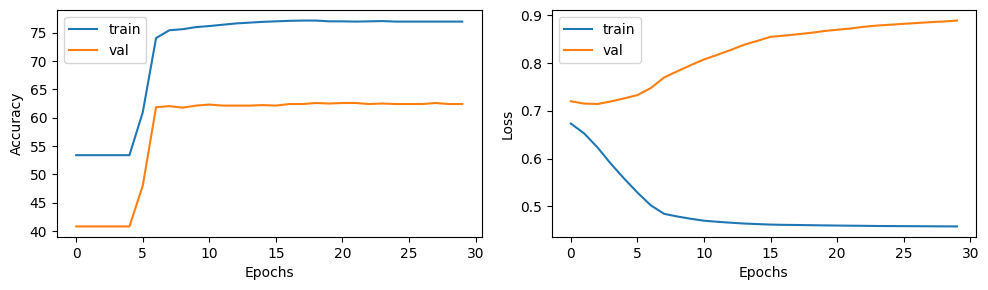

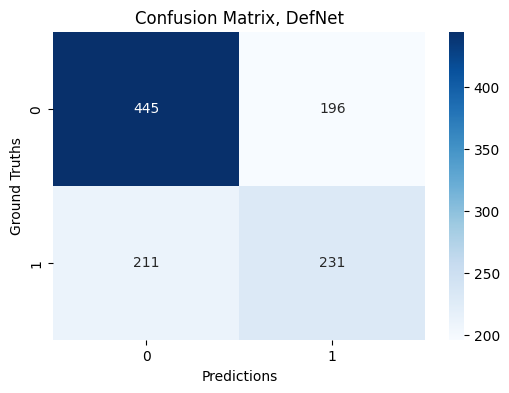

              precision    recall  f1-score   support

           0       0.68      0.69      0.69       641
           1       0.54      0.52      0.53       442

    accuracy                           0.62      1083
   macro avg       0.61      0.61      0.61      1083
weighted avg       0.62      0.62      0.62      1083



In [54]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
axes[0].plot(training_history['accuracy'], label='train')
axes[0].plot(validation_history['accuracy'], label='val')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(training_history['loss'], label='train')
axes[1].plot(validation_history['loss'], label='val')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
fig.tight_layout()

plt.show()

plot_confusion_matrix(small_net, val_loader, device)

##### Tau Threshold

In [55]:
# dopo avere scelto la net migliore
model_path = r'nets\compas\acc_nt_models\16_8_acc_nt_model_30.pt' 
small_net.load_state_dict(torch.load(model_path))
small_net.eval()

with torch.no_grad():
   probas= small_net.predict_proba_nn(X_val, device)
   y_pred= small_net.predict(X_val,device)

max_conf= probas.max(axis=1)

taus= np.linspace(0.50, 0.99, 50)
y_val_np= y_val.cpu().numpy() if torch.is_tensor(y_val) else np.array(y_val)

res= [evaluate_threshold(t, max_conf, y_pred, y_val_np) for t in taus]

best_tau = None
best_acc = -1
for tau, (acc_sel, cov, _) in zip(taus, res):
   if cov >= 0.6 and acc_sel > best_acc:
      best_acc = acc_sel 
      best_tau = tau


print(best_tau)
print(best_acc)


0.64
0.6666666666666666


#### Net 2 32/16

tau= 0.66

In [56]:
large_net= DeferralNet(input_size=8, hidden_layer1= 32, hidden_layer2= 16, output_size=2, dropout_coeff=0.2)


optimizer = optim.Adam(params=large_net.parameters(), 
                       lr=0.0005,
                       weight_decay= 1e-3
                    )

weights = torch.tensor([1.0, 1.3]).to(device)
criterion= nn.CrossEntropyLoss(weight=weights)

scheduler = StepLR(optimizer, step_size=8, gamma=0.5)

large_net.to(device)

DeferralNet(
  (softmax): Softmax(dim=1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=8, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=16, out_features=2, bias=True)
  )
)

##### Training

Training Results - Epoch[1] Avg accuracy: 0.62 Avg loss: 0.66
Validation Results - Epoch[1] Avg accuracy: 0.50 Avg loss: 0.69
End of Epoch 1: Learning Rate 0.0005
Epoch[2], Iter[100] Loss: 0.62
Training Results - Epoch[2] Avg accuracy: 0.64 Avg loss: 0.61
Validation Results - Epoch[2] Avg accuracy: 0.52 Avg loss: 0.68
End of Epoch 2: Learning Rate 0.0005
Epoch[3], Iter[200] Loss: 0.50
Training Results - Epoch[3] Avg accuracy: 0.71 Avg loss: 0.55
Validation Results - Epoch[3] Avg accuracy: 0.59 Avg loss: 0.67
End of Epoch 3: Learning Rate 0.0005
Training Results - Epoch[4] Avg accuracy: 0.74 Avg loss: 0.51
Validation Results - Epoch[4] Avg accuracy: 0.60 Avg loss: 0.68
End of Epoch 4: Learning Rate 0.0005
Epoch[5], Iter[300] Loss: 0.51
Training Results - Epoch[5] Avg accuracy: 0.75 Avg loss: 0.48
Validation Results - Epoch[5] Avg accuracy: 0.61 Avg loss: 0.71
End of Epoch 5: Learning Rate 0.0005
Epoch[6], Iter[400] Loss: 0.50
Training Results - Epoch[6] Avg accuracy: 0.76 Avg loss: 0.47

2026-02-10 16:32:37,144 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


Training Results - Epoch[21] Avg accuracy: 0.77 Avg loss: 0.45
Validation Results - Epoch[21] Avg accuracy: 0.62 Avg loss: 0.87
End of Epoch 21: Learning Rate 0.000125


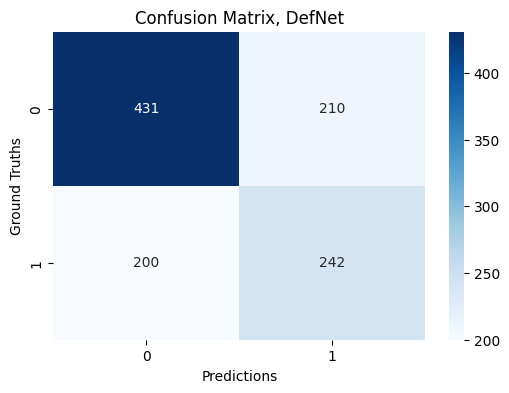

              precision    recall  f1-score   support

           0       0.68      0.67      0.68       641
           1       0.54      0.55      0.54       442

    accuracy                           0.62      1083
   macro avg       0.61      0.61      0.61      1083
weighted avg       0.62      0.62      0.62      1083



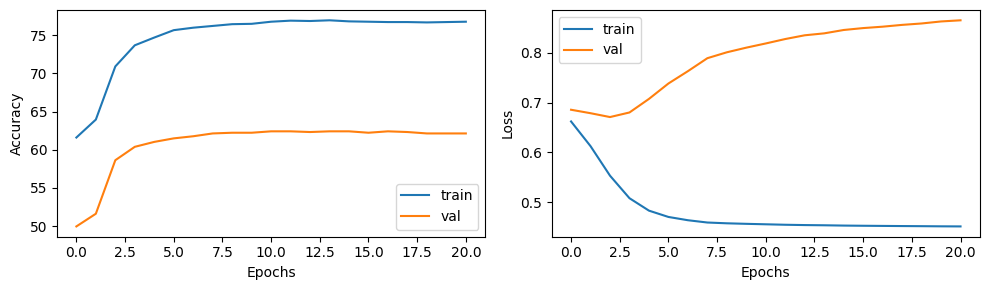

In [57]:
# Setting Ignite environment (preso direttamente da lab nn pytorch)

# ignite trainer
trainer = create_supervised_trainer(large_net, optimizer, criterion, device)

# validation e accuracy metrics are ignite metrics
training_history = {'accuracy':[],'loss':[]}
validation_history = {'accuracy':[],'loss':[]}
val_metrics = {"accuracy": Accuracy(), "loss": Loss(criterion)}

# ignite train and validation evaluators
train_evaluator = create_supervised_evaluator(large_net, metrics=val_metrics, device=device)
val_evaluator = create_supervised_evaluator(large_net, metrics=val_metrics, device=device)

# For logging purposes we add a function to be executed at the end of every log_interval-th iteration:
log_interval = 100

@trainer.on(Events.ITERATION_COMPLETED(every=log_interval))
def log_training_loss(engine):
    print(f"Epoch[{engine.state.epoch}], Iter[{engine.state.iteration}] Loss: {engine.state.output:.2f}")

# after a training epoch, computes training and validation metrics (train_eval on train_loader and val_eval on val_loader)
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(acc_nt_loader)
    metrics = train_evaluator.state.metrics
    training_history['accuracy'].append(metrics['accuracy']*100)
    training_history['loss'].append(metrics['loss'])
    print(f"Training Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['loss']:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    val_evaluator.run(val_loader)
    metrics = val_evaluator.state.metrics
    validation_history['accuracy'].append(metrics['accuracy']*100)
    validation_history['loss'].append(metrics['loss'])
    print(f"Validation Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['loss']:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def update_lr_scheduler(trainer):
    scheduler.step()
    lr = optimizer.param_groups[0]['lr']
    print(f"End of Epoch {trainer.state.epoch}: Learning Rate {lr}")


# return current value of any metric defined in val_metrics
def score_function(engine):
    return engine.state.metrics["accuracy"]


# define early stopping and model checkpoint
handler = EarlyStopping(patience=10, score_function=score_function, trainer=trainer)

checkpoint = ModelCheckpoint(
    dirname=r'.\nets\compas\acc_nt_models',
    filename_prefix='32_16_acc_nt',
    n_saved=1,
    create_dir=True,
    require_empty=False,
    global_step_transform=global_step_from_engine(trainer) # helps fetch the trainer's state
)

# Attach early stopping and model checkpoint to the trainer
val_evaluator.add_event_handler(Events.EPOCH_COMPLETED, handler)
val_evaluator.add_event_handler(Events.EPOCH_COMPLETED, checkpoint, {'model': large_net})


trainer.run(acc_nt_loader, max_epochs= 30)

plot_confusion_matrix(large_net, val_loader, device)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
axes[0].plot(training_history['accuracy'], label='train')
axes[0].plot(validation_history['accuracy'], label='val')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(training_history['loss'], label='train')
axes[1].plot(validation_history['loss'], label='val')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
fig.tight_layout()

plt.show()

##### Tau Threshold

In [58]:
# dopo avere scelto la net migliore

model_path = r'nets\compas\acc_nt_models\32_16_acc_nt_model_21.pt' 
large_net.load_state_dict(torch.load(model_path))
large_net.eval()

with torch.no_grad():
   probas= large_net.predict_proba_nn(X_val, device)
   y_pred= large_net.predict(X_val,device)

max_conf= probas.max(axis=1)

taus= np.linspace(0.50, 0.99, 50)
y_val_np= y_val.cpu().numpy() if torch.is_tensor(y_val) else np.array(y_val)

res= [evaluate_threshold(t, max_conf, y_pred, y_val_np) for t in taus]

best_tau = None
best_acc = -1
for tau, (acc_sel, cov, _) in zip(taus, res):
   if cov >= 0.6 and acc_sel > best_acc:
      best_acc = acc_sel 
      best_tau = tau


print(best_tau)
print(best_acc)



0.66
0.6773722627737226


### Anqi Mao style Deferral

papabili

  0.181633       0.746654       0.080295
  
  0.189796       0.745270       0.038302

In [81]:
def_data = []
pred_correct = []
C = []
alpha = 1.0  
beta = 0.1


for idx, row in df_acc_nt.iterrows():

    x_i = row[feat_order].values.tolist()
    
    
    # 1 se la macchina ha indovinato, 0 se ha sbagliato
    corr = 1.0 if row['machine prediction'] == row['ground truth'] else 0.0 # la ground truth originale
    
    # Costo di deferral C
    if row['provider'] == "H":
        c_i = beta # L'umano è stato scelto ed era utile
    else:
        c_i = alpha + beta # L'umano non è stato scelto, chiamarlo sarebbe un costo extra
    
    def_data.append(x_i)
    pred_correct.append(corr)
    C.append(c_i)

X_def = torch.tensor(def_data, dtype=torch.float32)
pred_correct = torch.tensor(pred_correct, dtype=torch.float32)
C = torch.tensor(C, dtype=torch.float32)


In [82]:
# sulla base di x_def chiamo la rete 

r_net= DeferralNet(input_size=X_def.shape[1], hidden_layer1=16, hidden_layer2=8, output_size=1, dropout_coeff= 0.2)


optimizer = torch.optim.Adam(r_net.parameters(), lr=1e-3)
dataset = torch.utils.data.TensorDataset(X_def, pred_correct, C)
loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
r_net.to(device)
r_net.train()

for epoch in range(20):
    running_loss = 0.0
    for xb, pc_b, c_b in loader:
      
        xb, pc_b, c_b = xb.to(device), pc_b.to(device), c_b.to(device)
        
        r_vals = r_net(xb).view(-1) 
        loss = deferral_loss(r_vals, pc_b, c_b)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    

    print(f"Epoch {epoch+1}/20 - Loss: {running_loss/len(loader):.4f}")
    
torch.save(r_net.state_dict(), os.path.join(save_dir, 'r_net_acc_nt.pth'))
print("✅ r_net salvata correttamente in", save_dir)

p_defer_calib = p_defer(X_cal.to('cuda'), r_net).flatten()

Epoch 1/20 - Loss: 0.5333
Epoch 2/20 - Loss: 0.4213
Epoch 3/20 - Loss: 0.3315
Epoch 4/20 - Loss: 0.3121
Epoch 5/20 - Loss: 0.3097
Epoch 6/20 - Loss: 0.3094
Epoch 7/20 - Loss: 0.3062
Epoch 8/20 - Loss: 0.3069
Epoch 9/20 - Loss: 0.3069
Epoch 10/20 - Loss: 0.3059
Epoch 11/20 - Loss: 0.3041
Epoch 12/20 - Loss: 0.3046
Epoch 13/20 - Loss: 0.3039
Epoch 14/20 - Loss: 0.3052
Epoch 15/20 - Loss: 0.3042
Epoch 16/20 - Loss: 0.3020
Epoch 17/20 - Loss: 0.3054
Epoch 18/20 - Loss: 0.3028
Epoch 19/20 - Loss: 0.3029
Epoch 20/20 - Loss: 0.3026
✅ r_net salvata correttamente in .\r_nets\compas


In [83]:
#richiamo la net 
large_net= DeferralNet(input_size= 8, hidden_layer1= 16, hidden_layer2= 8, output_size=2, dropout_coeff=0.2)

net_path= r"nets\compas\acc_nt_models\16_8_acc_nt_model_30.pt"
large_net.load_state_dict(torch.load(net_path, map_location=device))
large_net.to(device)

y_h_calib = large_net.predict(X_cal.to('cuda'), device)
y_gt_calib = y_cal.numpy()

thresholds = np.linspace(0.1, 0.5, 50)
calibration_results = []

for tr in thresholds:
    # Maschera di chi viene mandato all'umano
    defer_mask = (p_defer_calib >= tr)
    
    # ACCURATEZZA TEAM:
    # Se defer_mask è True (H), diamo 1 (assumiamo che l'umano indovini)
    # Se defer_mask è False (M), verifichiamo se h ha indovinato il target vero
    correct_decisions = np.where(defer_mask, 1.0, (y_h_calib == y_gt_calib))
    team_acc = np.mean(correct_decisions)
    
    # Tasso di Deferral: quante istanze la r_net ha "scartato"
    defer_rate = np.mean(defer_mask)
    
    calibration_results.append({
        'tau_r': tr,
        'team_accuracy': team_acc,
        'deferral_rate': defer_rate
    })

print(pd.DataFrame(calibration_results))

       tau_r  team_accuracy  deferral_rate
0   0.100000       0.995385       0.976004
1   0.108163       0.989386       0.952469
2   0.116327       0.981541       0.922935
3   0.124490       0.962621       0.862944
4   0.132653       0.938163       0.779419
5   0.140816       0.913244       0.682510
6   0.148980       0.875404       0.571297
7   0.157143       0.828796       0.432856
8   0.165306       0.784956       0.267651
9   0.173469       0.758191       0.152284
10  0.181633       0.746654       0.080295
11  0.189796       0.745270       0.038302
12  0.197959       0.745270       0.023535
13  0.206122       0.745270       0.014767
14  0.214286       0.745270       0.008768
15  0.222449       0.745270       0.004615
16  0.230612       0.745270       0.000923
17  0.238776       0.745270       0.000461
18  0.246939       0.745270       0.000000
19  0.255102       0.745270       0.000000
20  0.263265       0.745270       0.000000
21  0.271429       0.745270       0.000000
22  0.27959

## Expert: Inaccurate, Not Trusting

In [59]:
# retrieving the calibration split 

df_val= pd.read_csv(r".\processed_data\compas\calibration_datasets\inacc_nt_calibration")
df_val= df_val.rename(columns={'did_recid': 'ground_truth'})  # per non confondermi

In [60]:
# retrieving data

df_inacc_nt = pd.read_csv(r".\processed_data\compas\hic_results_ds\hic_inaccurate_not_trusting")
df_inacc_nt.head(n=5)

df_inacc_nt= df_inacc_nt.rename(columns={'did_recid':'g_truth'})  

df_inacc_nt.to_csv(r".\processed_data\compas\switch_ds\inacc_nt_switch", index= False) # questa versione di df è quella che viene passata a start Mic come df switch


In [61]:
feat_order = [c for c in df_inacc_nt.columns if c not in [
    'did_recid', 'g_truth', 'ground truth', 
    'proba_model', 'provider', 'machine prediction', 'expert prediction'
]]


X_cal = torch.tensor(df_inacc_nt[feat_order].values, dtype=torch.float32)
y_cal = torch.tensor(df_inacc_nt['g_truth'].values, dtype=torch.long)

inacc_nt_df = TensorDataset(X_cal, y_cal)
inacc_nt_loader = DataLoader(inacc_nt_df, batch_size=64, shuffle=False)


X_val = torch.tensor(df_val[feat_order].values, dtype=torch.float32)
y_val = torch.tensor(df_val['ground_truth'].values, dtype=torch.long)

val_d = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_d, batch_size=32, shuffle=False)

### Deferral Strat 1

#### Net 1

tau= 0.52

In [62]:
small_net= DeferralNet(input_size=8, hidden_layer1= 16, hidden_layer2= 8, output_size=2, dropout_coeff=0.2)

small_net.to(device)

optimizer = optim.Adam(params=small_net.parameters(), 
                       lr=0.0005,
                       weight_decay= 1e-3
                    )

weights = torch.tensor([1.0, 1.3]).to(device)

criterion= nn.CrossEntropyLoss(weight=weights)
scheduler = StepLR(optimizer, step_size=8, gamma=0.5)


##### Training

In [63]:
# Setting Ignite environment (preso direttamente da lab nn pytorch)

# ignite trainer
trainer = create_supervised_trainer(small_net, optimizer, criterion, device)

# validation e accuracy metrics are ignite metrics
training_history = {'accuracy':[],'loss':[]}
validation_history = {'accuracy':[],'loss':[]}
val_metrics = {"accuracy": Accuracy(), "loss": Loss(criterion)}

# ignite train and validation evaluators
train_evaluator = create_supervised_evaluator(small_net, metrics=val_metrics, device=device)
val_evaluator = create_supervised_evaluator(small_net, metrics=val_metrics, device=device)

# For logging purposes we add a function to be executed at the end of every log_interval-th iteration:
log_interval = 100

@trainer.on(Events.ITERATION_COMPLETED(every=log_interval))
def log_training_loss(engine):
    print(f"Epoch[{engine.state.epoch}], Iter[{engine.state.iteration}] Loss: {engine.state.output:.2f}")

# after a training epoch, computes training and validation metrics (train_eval on train_loader and val_eval on val_loader)
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(inacc_nt_loader)
    metrics = train_evaluator.state.metrics
    training_history['accuracy'].append(metrics['accuracy']*100)
    training_history['loss'].append(metrics['loss'])
    print(f"Training Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['loss']:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    val_evaluator.run(val_loader)
    metrics = val_evaluator.state.metrics
    validation_history['accuracy'].append(metrics['accuracy']*100)
    validation_history['loss'].append(metrics['loss'])
    print(f"Validation Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['loss']:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def update_lr_scheduler(trainer):
    scheduler.step()
    lr = optimizer.param_groups[0]['lr']
    print(f"End of Epoch {trainer.state.epoch}: Learning Rate {lr}")

# return current value of any metric defined in val_metrics
def score_function(engine):
    return engine.state.metrics["accuracy"]


# define early stopping and model checkpoint
handler = EarlyStopping(patience=10, score_function=score_function, trainer=trainer)

checkpoint = ModelCheckpoint(
    dirname=r'.\nets\compas\inacc_nt_models',
    filename_prefix='16_8_inacc_nt',
    n_saved=1,
    create_dir=True,
    require_empty=False,
    global_step_transform=global_step_from_engine(trainer) # helps fetch the trainer's state
)

# Attach early stopping and model checkpoint to the trainer
val_evaluator.add_event_handler(Events.EPOCH_COMPLETED, handler)
val_evaluator.add_event_handler(Events.EPOCH_COMPLETED, checkpoint, {'model': small_net})


trainer.run(inacc_nt_loader, max_epochs= 30)

Training Results - Epoch[1] Avg accuracy: 0.43 Avg loss: 0.71
Validation Results - Epoch[1] Avg accuracy: 0.59 Avg loss: 0.69
End of Epoch 1: Learning Rate 0.0005
Training Results - Epoch[2] Avg accuracy: 0.49 Avg loss: 0.69
Validation Results - Epoch[2] Avg accuracy: 0.59 Avg loss: 0.69
End of Epoch 2: Learning Rate 0.0005
Epoch[3], Iter[100] Loss: 0.66
Training Results - Epoch[3] Avg accuracy: 0.63 Avg loss: 0.67
Validation Results - Epoch[3] Avg accuracy: 0.49 Avg loss: 0.69
End of Epoch 3: Learning Rate 0.0005
Training Results - Epoch[4] Avg accuracy: 0.58 Avg loss: 0.64
Validation Results - Epoch[4] Avg accuracy: 0.43 Avg loss: 0.69
End of Epoch 4: Learning Rate 0.0005
Training Results - Epoch[5] Avg accuracy: 0.58 Avg loss: 0.60
Validation Results - Epoch[5] Avg accuracy: 0.42 Avg loss: 0.69
End of Epoch 5: Learning Rate 0.0005
Epoch[6], Iter[200] Loss: 0.60
Training Results - Epoch[6] Avg accuracy: 0.58 Avg loss: 0.57
Validation Results - Epoch[6] Avg accuracy: 0.44 Avg loss: 0.

2026-02-10 16:33:31,539 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


Validation Results - Epoch[10] Avg accuracy: 0.54 Avg loss: 0.73
End of Epoch 10: Learning Rate 0.00025
Training Results - Epoch[11] Avg accuracy: 0.69 Avg loss: 0.51
Validation Results - Epoch[11] Avg accuracy: 0.55 Avg loss: 0.73
End of Epoch 11: Learning Rate 0.00025


State:
	iteration: 374
	epoch: 11
	epoch_length: 34
	max_epochs: 30
	output: 0.520959198474884
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

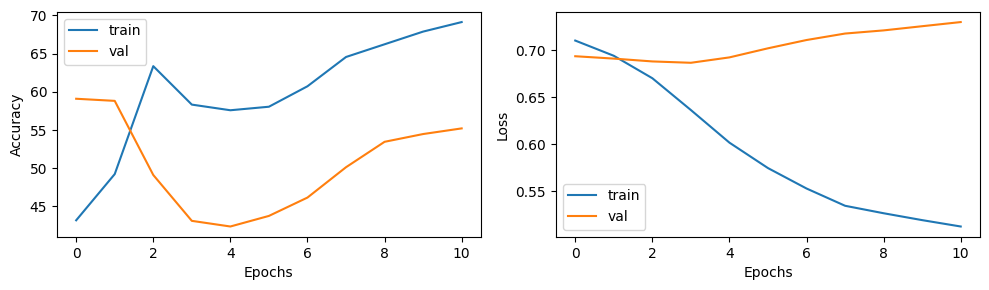

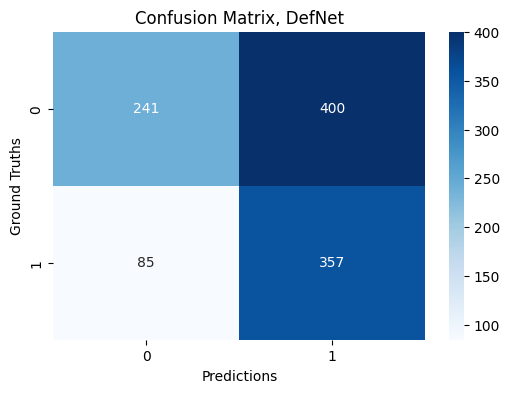

              precision    recall  f1-score   support

           0       0.74      0.38      0.50       641
           1       0.47      0.81      0.60       442

    accuracy                           0.55      1083
   macro avg       0.61      0.59      0.55      1083
weighted avg       0.63      0.55      0.54      1083



In [64]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
axes[0].plot(training_history['accuracy'], label='train')
axes[0].plot(validation_history['accuracy'], label='val')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(training_history['loss'], label='train')
axes[1].plot(validation_history['loss'], label='val')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
fig.tight_layout()

plt.show()

plot_confusion_matrix(small_net, val_loader, device)

##### Tau Threshold

In [65]:
# dopo avere scelto la net migliore

model_path = r'nets\compas\inacc_nt_models\16_8_inacc_nt_model_11.pt' 
small_net.load_state_dict(torch.load(model_path))
small_net.eval()

with torch.no_grad():
   probas= small_net.predict_proba_nn(X_val, device)
   y_pred= small_net.predict(X_val,device)

max_conf= probas.max(axis=1)

taus= np.linspace(0.50, 0.99, 50)
y_val_np= y_val.cpu().numpy() if torch.is_tensor(y_val) else np.array(y_val)

res= [evaluate_threshold(t, max_conf, y_pred, y_val_np) for t in taus]

best_tau = None
best_acc = -1
for tau, (acc_sel, cov, _) in zip(taus, res):
   if cov >= 0.6 and acc_sel > best_acc:
      best_acc = acc_sel 
      best_tau = tau


print(best_tau)
print(best_acc)


0.52
0.5609480812641083


#### Net 2

tau= 0.5700000000000001

In [66]:
large_net= DeferralNet(input_size=8, hidden_layer1= 32, hidden_layer2= 16, output_size=2, dropout_coeff=0.2)

large_net.to(device)

optimizer = optim.Adam(params=large_net.parameters(), 
                       lr=0.0005,
                       weight_decay= 1e-3
                    )


weights = torch.tensor([1.0, 1.3]).to(device)

criterion= nn.CrossEntropyLoss(weight=weights)
scheduler = StepLR(optimizer, step_size=8, gamma=0.5)


##### Training

Training Results - Epoch[1] Avg accuracy: 0.60 Avg loss: 0.66
Validation Results - Epoch[1] Avg accuracy: 0.43 Avg loss: 0.68
End of Epoch 1: Learning Rate 0.0005
Training Results - Epoch[2] Avg accuracy: 0.57 Avg loss: 0.62
Validation Results - Epoch[2] Avg accuracy: 0.41 Avg loss: 0.68
End of Epoch 2: Learning Rate 0.0005
Epoch[3], Iter[100] Loss: 0.52
Training Results - Epoch[3] Avg accuracy: 0.59 Avg loss: 0.58
Validation Results - Epoch[3] Avg accuracy: 0.44 Avg loss: 0.69
End of Epoch 3: Learning Rate 0.0005
Training Results - Epoch[4] Avg accuracy: 0.69 Avg loss: 0.54
Validation Results - Epoch[4] Avg accuracy: 0.53 Avg loss: 0.70
End of Epoch 4: Learning Rate 0.0005
Training Results - Epoch[5] Avg accuracy: 0.73 Avg loss: 0.51
Validation Results - Epoch[5] Avg accuracy: 0.57 Avg loss: 0.72
End of Epoch 5: Learning Rate 0.0005
Epoch[6], Iter[200] Loss: 0.52
Training Results - Epoch[6] Avg accuracy: 0.74 Avg loss: 0.49
Validation Results - Epoch[6] Avg accuracy: 0.58 Avg loss: 0.

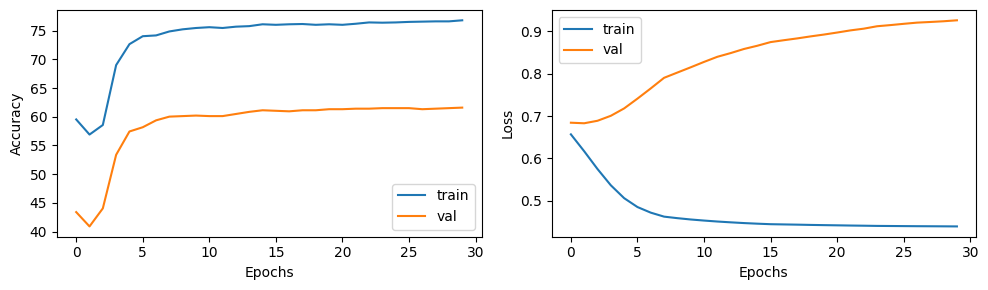

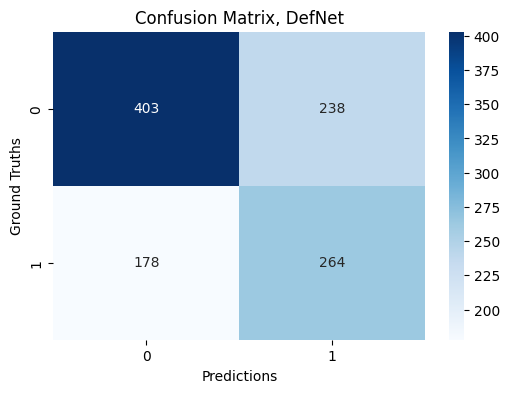

              precision    recall  f1-score   support

           0       0.69      0.63      0.66       641
           1       0.53      0.60      0.56       442

    accuracy                           0.62      1083
   macro avg       0.61      0.61      0.61      1083
weighted avg       0.63      0.62      0.62      1083



In [67]:
# Setting Ignite environment (preso direttamente da lab nn pytorch)

# ignite trainer
trainer = create_supervised_trainer(large_net, optimizer, criterion, device)

# validation e accuracy metrics are ignite metrics
training_history = {'accuracy':[],'loss':[]}
validation_history = {'accuracy':[],'loss':[]}
val_metrics = {"accuracy": Accuracy(), "loss": Loss(criterion)}

# ignite train and validation evaluators
train_evaluator = create_supervised_evaluator(large_net, metrics=val_metrics, device=device)
val_evaluator = create_supervised_evaluator(large_net, metrics=val_metrics, device=device)

# For logging purposes we add a function to be executed at the end of every log_interval-th iteration:
log_interval = 100

@trainer.on(Events.ITERATION_COMPLETED(every=log_interval))
def log_training_loss(engine):
    print(f"Epoch[{engine.state.epoch}], Iter[{engine.state.iteration}] Loss: {engine.state.output:.2f}")

# after a training epoch, computes training and validation metrics (train_eval on train_loader and val_eval on val_loader)
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(inacc_nt_loader)
    metrics = train_evaluator.state.metrics
    training_history['accuracy'].append(metrics['accuracy']*100)
    training_history['loss'].append(metrics['loss'])
    print(f"Training Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['loss']:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    val_evaluator.run(val_loader)
    metrics = val_evaluator.state.metrics
    validation_history['accuracy'].append(metrics['accuracy']*100)
    validation_history['loss'].append(metrics['loss'])
    print(f"Validation Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['loss']:.2f}")


@trainer.on(Events.EPOCH_COMPLETED)
def update_lr_scheduler(trainer):
    scheduler.step()
    lr = optimizer.param_groups[0]['lr']
    print(f"End of Epoch {trainer.state.epoch}: Learning Rate {lr}")


# return current value of any metric defined in val_metrics
def score_function(engine):
    return engine.state.metrics["accuracy"]


# define early stopping and model checkpoint
handler = EarlyStopping(patience=10, score_function=score_function, trainer=trainer)

checkpoint = ModelCheckpoint(
    dirname=r'.\nets\compas\inacc_nt_models',
    filename_prefix='32_16_inacc_nt',
    n_saved=1,
    create_dir=True,
    require_empty=False,
    global_step_transform=global_step_from_engine(trainer) # helps fetch the trainer's state
)

# Attach early stopping and model checkpoint to the trainer
val_evaluator.add_event_handler(Events.EPOCH_COMPLETED, handler)
val_evaluator.add_event_handler(Events.EPOCH_COMPLETED, checkpoint, {'model': large_net})


trainer.run(inacc_nt_loader, max_epochs= 30)



fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
axes[0].plot(training_history['accuracy'], label='train')
axes[0].plot(validation_history['accuracy'], label='val')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(training_history['loss'], label='train')
axes[1].plot(validation_history['loss'], label='val')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
fig.tight_layout()

plt.show()

plot_confusion_matrix(large_net, val_loader, device)

##### Tau Threshold

In [68]:
# dopo avere scelto la net migliore
model_path = r'nets\compas\inacc_nt_models\32_16_inacc_nt_model_30.pt' 
large_net.load_state_dict(torch.load(model_path))
large_net.eval()

with torch.no_grad():
   probas= large_net.predict_proba_nn(X_val, device)
   y_pred= large_net.predict(X_val,device)

max_conf= probas.max(axis=1)

taus= np.linspace(0.50, 0.99, 50)
y_val_np= y_val.cpu().numpy() if torch.is_tensor(y_val) else np.array(y_val)

res= [evaluate_threshold(t, max_conf, y_pred, y_val_np) for t in taus]

best_tau = None
best_acc = -1
for tau, (acc_sel, cov, _) in zip(taus, res):
   if cov >= 0.6 and acc_sel > best_acc:
      best_acc = acc_sel 
      best_tau = tau


print(best_tau)
print(best_acc)



0.5700000000000001
0.6258205689277899


### Anqi Mao Strat


papabili

  0.171429       0.707430       0.158745
  
  0.179592       0.694047       0.052607

In [84]:
def_data = []
pred_correct = []
C = []
alpha = 1.0  
beta = 0.1


for idx, row in df_inacc_nt.iterrows():

    x_i = row[feat_order].values.tolist()
    
    
    # 1 se la macchina ha indovinato, 0 se ha sbagliato
    corr = 1.0 if row['machine prediction'] == row['ground truth'] else 0.0 # la ground truth originale
    
    # Costo di deferral C
    if row['provider'] == "H":
        c_i = beta # L'umano è stato scelto ed era utile
    else:
        c_i = alpha + beta # L'umano non è stato scelto, chiamarlo sarebbe un costo extra
    
    def_data.append(x_i)
    pred_correct.append(corr)
    C.append(c_i)

X_def = torch.tensor(def_data, dtype=torch.float32)
pred_correct = torch.tensor(pred_correct, dtype=torch.float32)
C = torch.tensor(C, dtype=torch.float32)



In [85]:
# sulla base di x_def chiamo la rete 

r_net= DeferralNet(input_size=X_def.shape[1], hidden_layer1=16, hidden_layer2=8, output_size=1, dropout_coeff= 0.2)


optimizer = torch.optim.Adam(r_net.parameters(), lr=1e-3)
dataset = torch.utils.data.TensorDataset(X_def, pred_correct, C)
loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
r_net.to(device)
r_net.train()

for epoch in range(20):
    running_loss = 0.0
    for xb, pc_b, c_b in loader:
      
        xb, pc_b, c_b = xb.to(device), pc_b.to(device), c_b.to(device)
        
        r_vals = r_net(xb).view(-1) # .view(-1) assicura che r sia un vettore piatto
    
        loss = deferral_loss(r_vals, pc_b, c_b)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    

    print(f"Epoch {epoch+1}/20 - Loss: {running_loss/len(loader):.4f}")
    
torch.save(r_net.state_dict(), os.path.join(save_dir, 'r_net_inacc_nt.pth'))
print("✅ r_net salvata correttamente in", save_dir)
p_defer_calib = p_defer(X_cal.to('cuda'), r_net).flatten()


Epoch 1/20 - Loss: 0.3833
Epoch 2/20 - Loss: 0.3251
Epoch 3/20 - Loss: 0.3029
Epoch 4/20 - Loss: 0.3004
Epoch 5/20 - Loss: 0.3001
Epoch 6/20 - Loss: 0.2991
Epoch 7/20 - Loss: 0.2968
Epoch 8/20 - Loss: 0.2980
Epoch 9/20 - Loss: 0.2971
Epoch 10/20 - Loss: 0.2964
Epoch 11/20 - Loss: 0.2956
Epoch 12/20 - Loss: 0.2951
Epoch 13/20 - Loss: 0.2938
Epoch 14/20 - Loss: 0.2942
Epoch 15/20 - Loss: 0.2950
Epoch 16/20 - Loss: 0.2942
Epoch 17/20 - Loss: 0.2929
Epoch 18/20 - Loss: 0.2936
Epoch 19/20 - Loss: 0.2930
Epoch 20/20 - Loss: 0.2938
✅ r_net salvata correttamente in .\r_nets\compas


In [88]:
#richiamo la net 
large_net= DeferralNet(input_size= 8, hidden_layer1= 16, hidden_layer2= 8, output_size=2, dropout_coeff=0.2)

net_path= r"nets\compas\inacc_nt_models\16_8_inacc_nt_model_11.pt"
large_net.load_state_dict(torch.load(net_path, map_location=device))
large_net.to(device)

y_h_calib = large_net.predict(X_cal.to('cuda'), device)
y_gt_calib = y_cal.numpy()

thresholds = np.linspace(0.0, 0.4, 50)
calibration_results = []

for tr in thresholds:
    # Maschera di chi viene mandato all'umano
    defer_mask = (p_defer_calib >= tr)
    
    # ACCURATEZZA TEAM:
    # Se defer_mask è True (H), diamo 1 (assumiamo che l'umano indovini)
    # Se defer_mask è False (M), verifichiamo se h ha indovinato il target vero
    correct_decisions = np.where(defer_mask, 1.0, (y_h_calib == y_gt_calib))
    team_acc = np.mean(correct_decisions)
    
    # Tasso di Deferral: quante istanze la r_net ha "scartato"
    defer_rate = np.mean(defer_mask)
    
    calibration_results.append({
        'tau_r': tr,
        'team_accuracy': team_acc,
        'deferral_rate': defer_rate
    })

print(pd.DataFrame(calibration_results))

       tau_r  team_accuracy  deferral_rate
0   0.000000       1.000000       1.000000
1   0.008163       1.000000       1.000000
2   0.016327       1.000000       1.000000
3   0.024490       1.000000       1.000000
4   0.032653       1.000000       1.000000
5   0.040816       1.000000       1.000000
6   0.048980       1.000000       1.000000
7   0.057143       1.000000       1.000000
8   0.065306       1.000000       1.000000
9   0.073469       1.000000       1.000000
10  0.081633       1.000000       0.999539
11  0.089796       1.000000       0.997231
12  0.097959       0.998616       0.991694
13  0.106122       0.996308       0.980618
14  0.114286       0.989848       0.959391
15  0.122449       0.976927       0.914167
16  0.130612       0.945547       0.828796
17  0.138776       0.906784       0.724504
18  0.146939       0.836179       0.577296
19  0.155102       0.788186       0.448085
20  0.163265       0.735579       0.299492
21  0.171429       0.707430       0.158745
22  0.17959